In [2]:
# from __future__ import print_function, unicode_literals, absolute_import, division
# import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
# from csbdeep.utils.plot_utils import *
# from csbdeep.data.transform import Transform

from stardist import fill_label_holes, random_label_cmap

# from stardist import _draw_polygons
from stardist.models import Config2D, StarDist2D, StarDistData2D, base
# from stardist.models.sample_patches import sample_patches

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

np.random.seed(42)

%reload_ext autoreload
%autoreload 2

print(tf.__version__)

Using TensorFlow backend.


1.14.0


In [3]:
import os
HOME = Path('/home/qzt')
PATH = "data/dsb2018_sub1/"
# PATH = "data/centuri/train/"
# path = os.path.join(HOME, "data/dsb2018/dsb2018_sub1/images/*.tif")
pathX = os.path.join(HOME, PATH+"images/*.tif")
pathY = os.path.join(HOME, PATH+"masks/*.tif")
X_file = sorted(glob(pathX))
Y_file = sorted(glob(pathY))
print(len(X_file), len(Y_file))

292 292


In [4]:
X = list(map(imread,X_file))
Y = list(map(imread,Y_file))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

## manual assign train/val index for debugging
# ind_train = [1,2,3,4]
# ind_val = [0]

X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_file_val   = [X_file[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

100%|██████████| 292/292 [00:01<00:00, 230.07it/s]

number of images: 292
- training:       248
- validation:      44


In [4]:
# err = [5,6,8,13,18,35]
# X_err = [X_val[i] for i in err]

# fig, ax = plt.subplots(3,2, figsize=(16,16))
# for i,(a,x,f) in enumerate(zip(ax.flat, X_err, X_file_val)):
#     a.imshow(x if x.ndim==2 else x[...,0], cmap='magma')
#     a.set_title(f'{err[i]}_{x.shape}')
#     print(os.path.basename(f))
# [a.axis('off') for a in ax.flat]
# plt.tight_layout()

## Load model

In [5]:
from keras import backend as K
K.clear_session()
# sess = K.get_session()
# tf.reset_default_graph()
model = StarDist2D(None, name='stardist_depth_3_augment_True_grid_2_2_epochs_800', basedir='../../models')
# model = StarDist2D(None, name='stardist_tune', basedir='unet01')

if not model._model_prepared:
    model.prepare_for_training()
model.config

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Config2D(EDT_prob_threshold=0, axes='YXC', backbone='unet', feature_dropout=0, grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], norm_by_mask=True, train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=800, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=[1, 0.2], train_n_val_patches=None, train_one_cycle_lr_max=None, train_patch_size=[256, 256], train_reduce_lr={'factor': 0.5, 'patience': 80, 'min_delta': 0, 'verbose': True}, train_shape_completion=False, train_steps_per_epoch=400, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=[3, 3], unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=3

## Crate Data generator

In [55]:
nr = model.config.n_rays
ps = model.config.train_patch_size
grid = model.config.grid
bs = len(X_val)
data = StarDistData2D(X_val, Y_val, batch_size=bs, n_rays=nr, grid=grid, patch_size=ps, 
                      shuffle_start=False,augmenter=None, shape_completion=False, b=0, 
                      border_R = 9, black_border=True)

In [56]:
# %%debug
## data[0] is the first batch of the generator
## data[0][0] is the X part of each batch, which is a list of [img, dist_mask]
## data[0][1] is the Y part of each batch, which is a tuple of [prob, dist] 
X_batch, Y_batch = data[0]

## Create plotting function

In [12]:
def show_img(arrs, vmin=None, vmax=None, cmap='magma', figsize=(8,8)):
    ## arrs is img or img list array
    ## arr can be a single img or a list of images (will be plot in cols)
    for i, arr in enumerate(arrs):
        col = len(arr)
        plt.figure(figsize=figsize)
        plt.title(i)
        for c in range(0,col):
            plt.subplot(1, col, c+1)
            if isinstance(arr, list): img = arr[c]
            else: img = arr
            plt.imshow(np.squeeze(img),vmin=vmin, vmax=vmax, cmap=cmap)
            plt.axis('off')

/home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


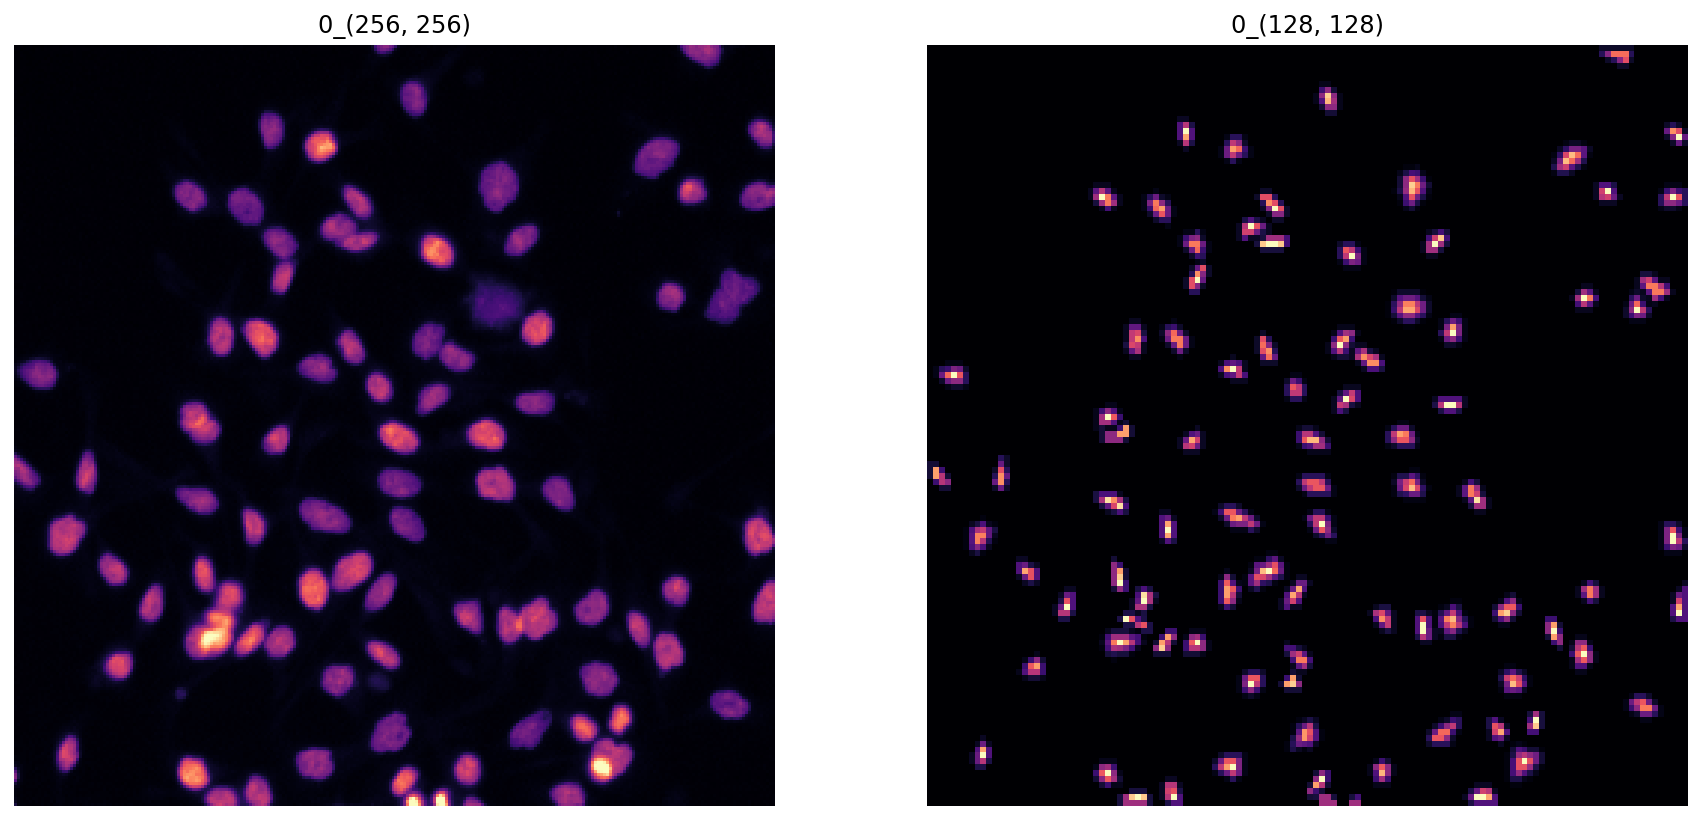

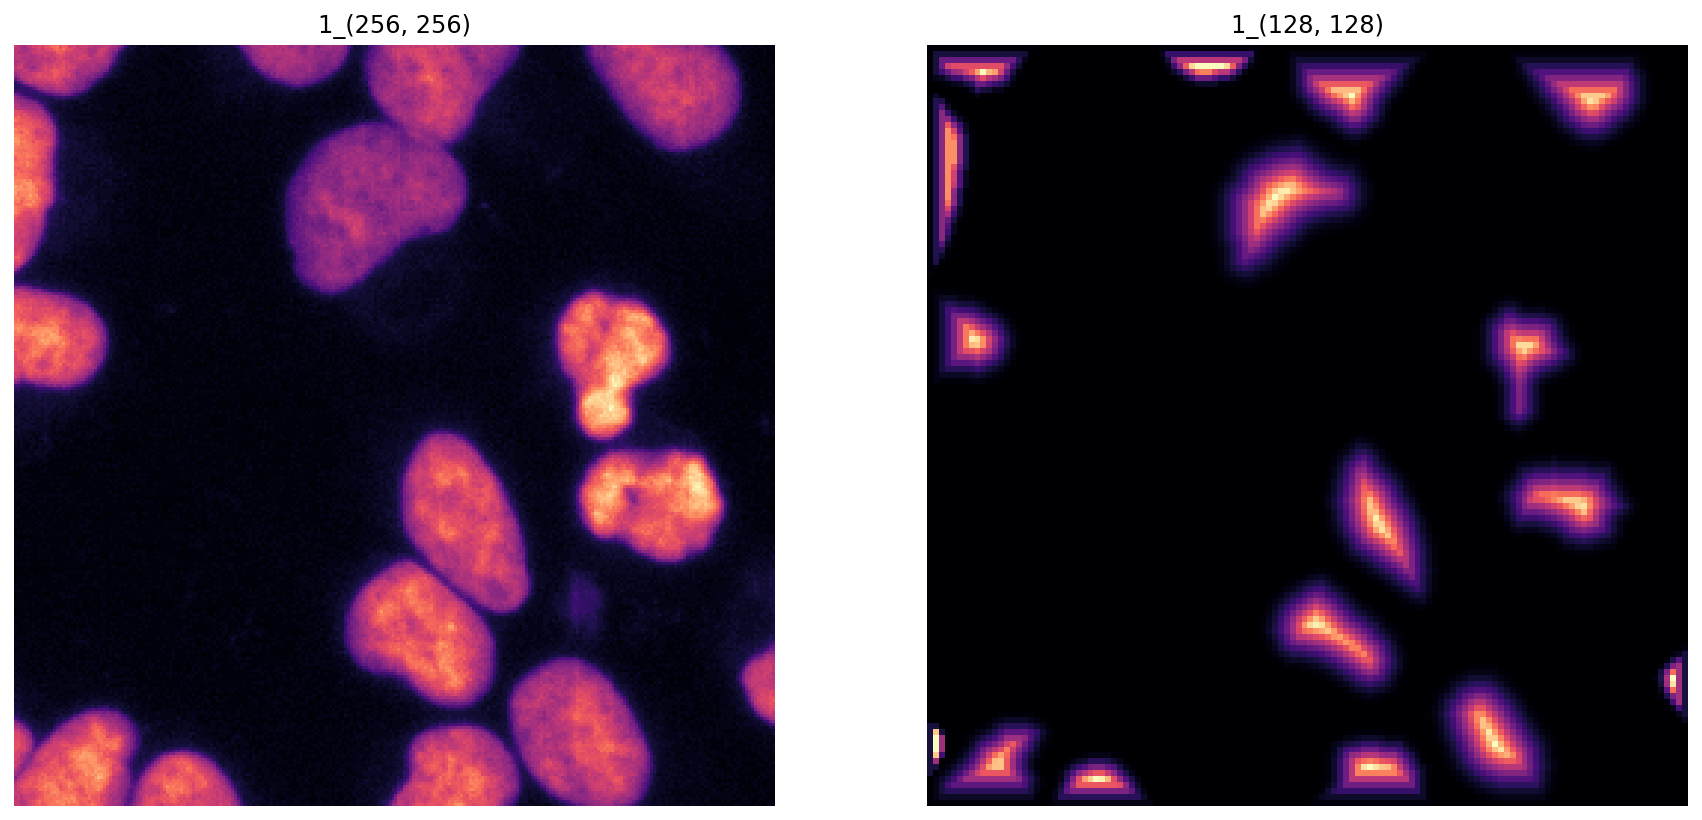

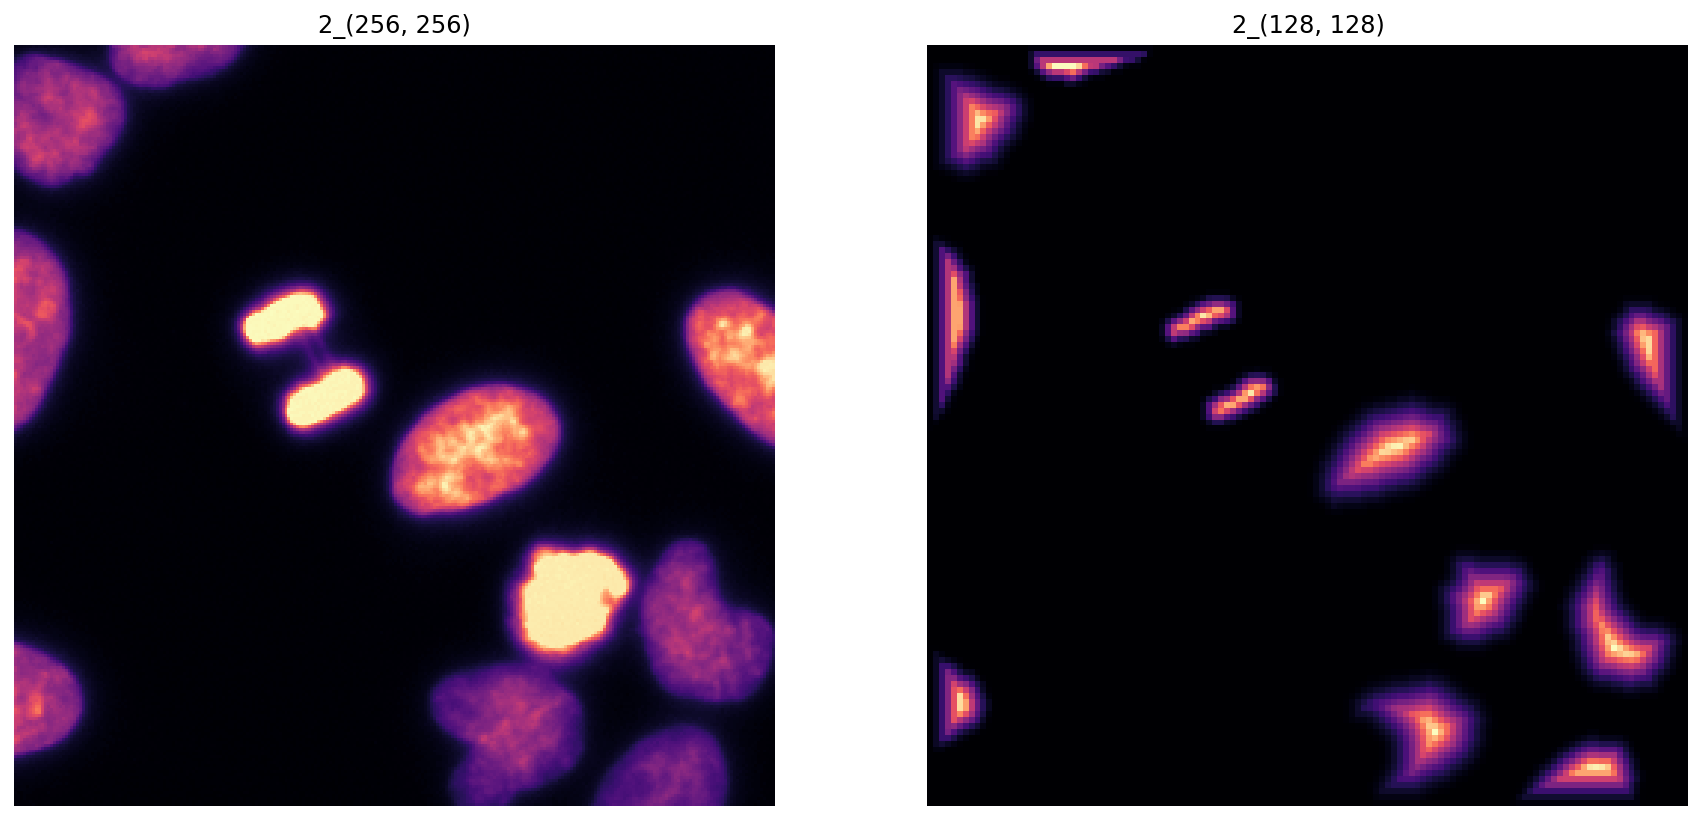

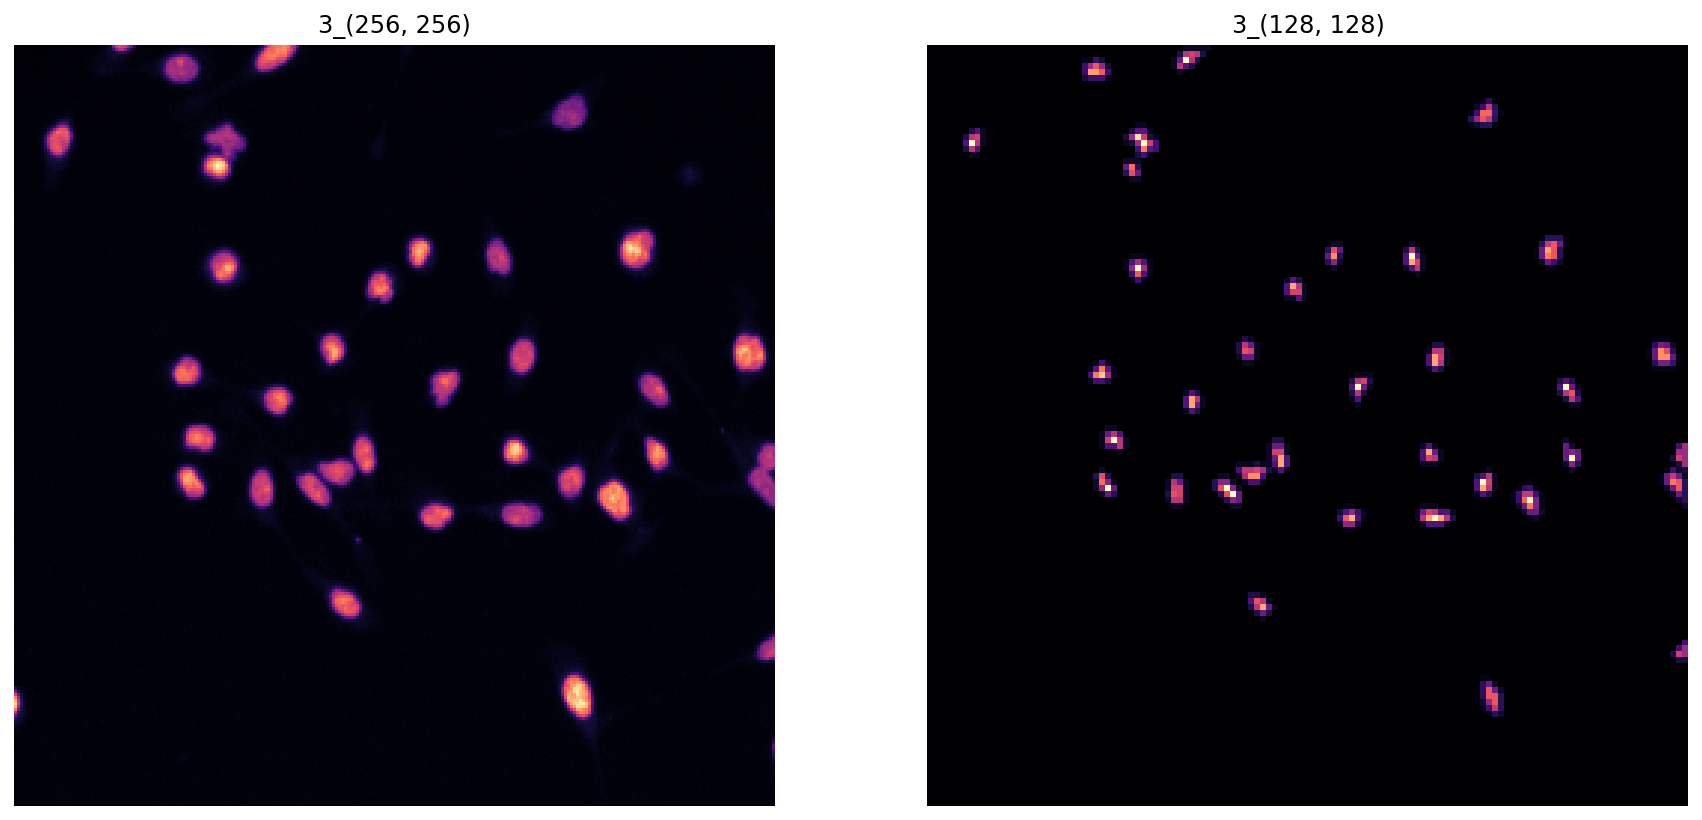

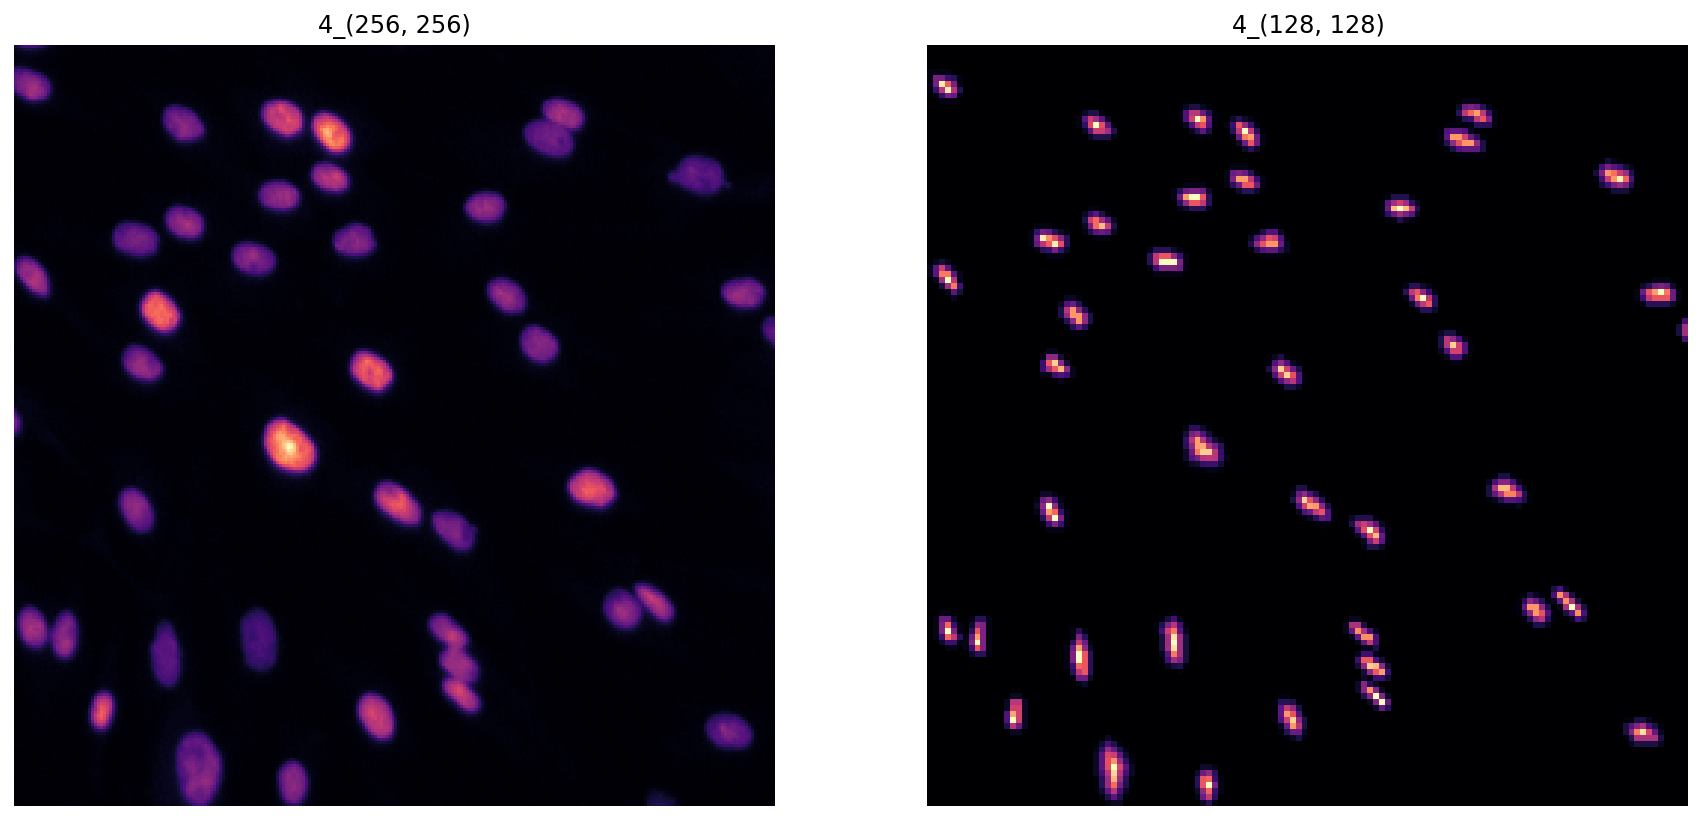

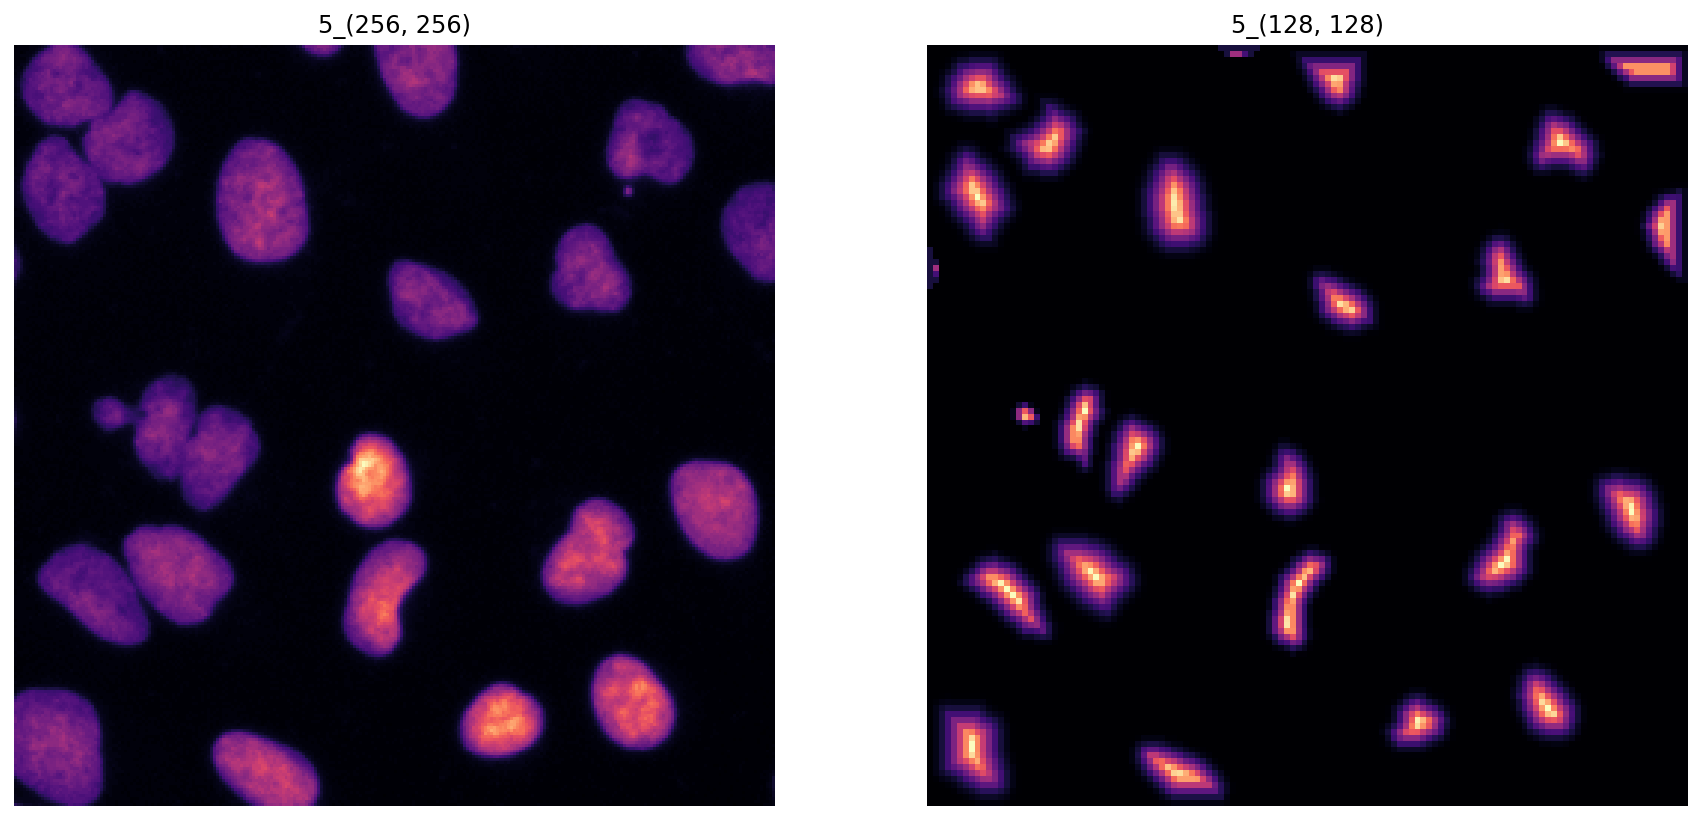

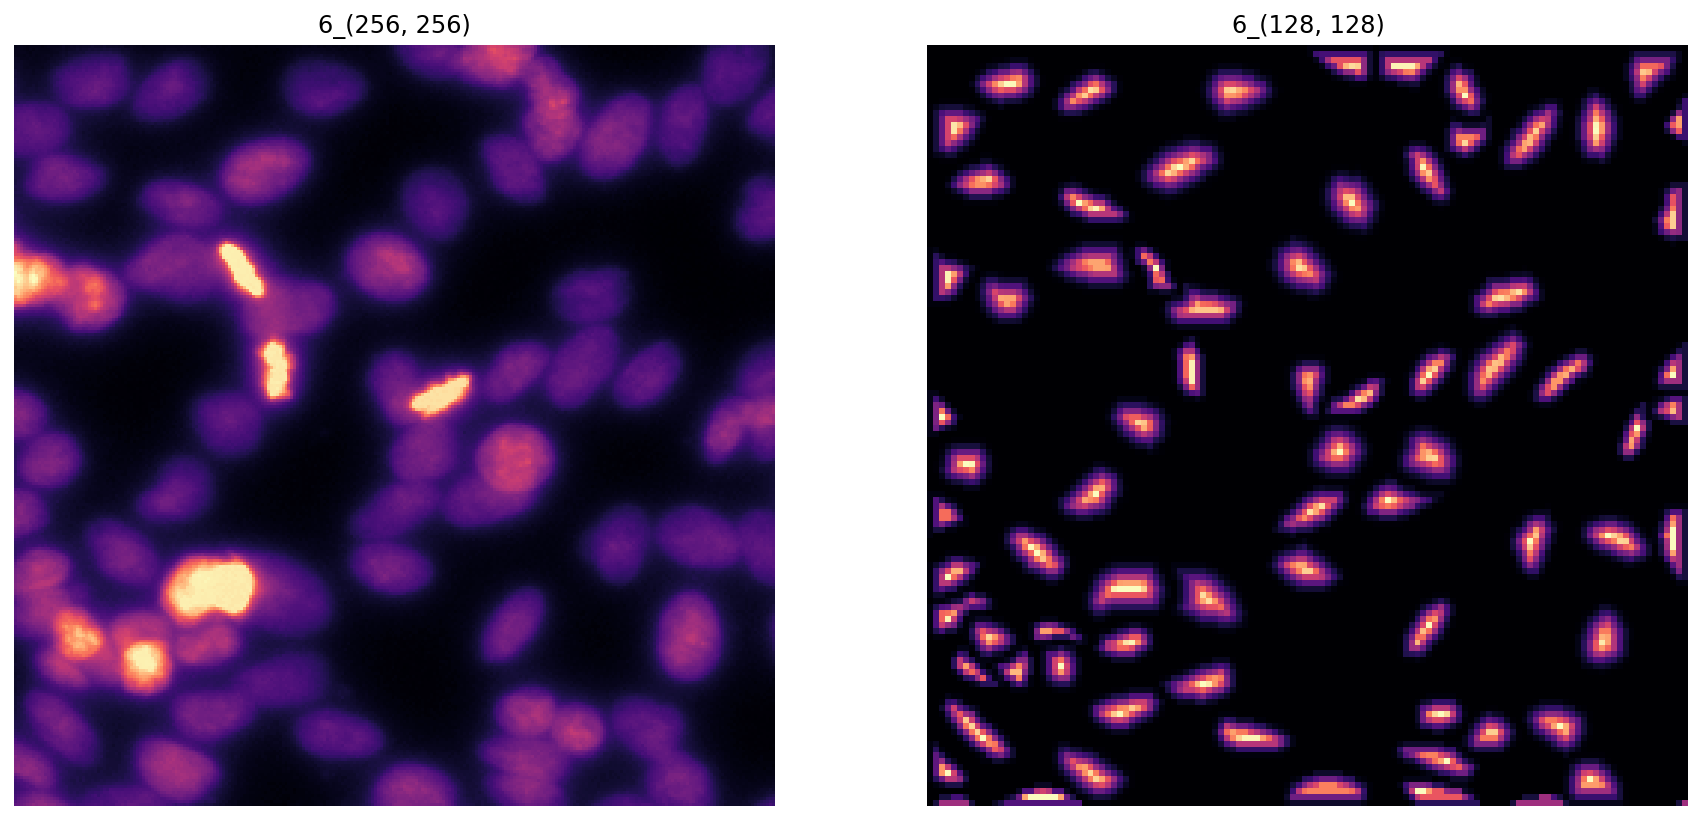

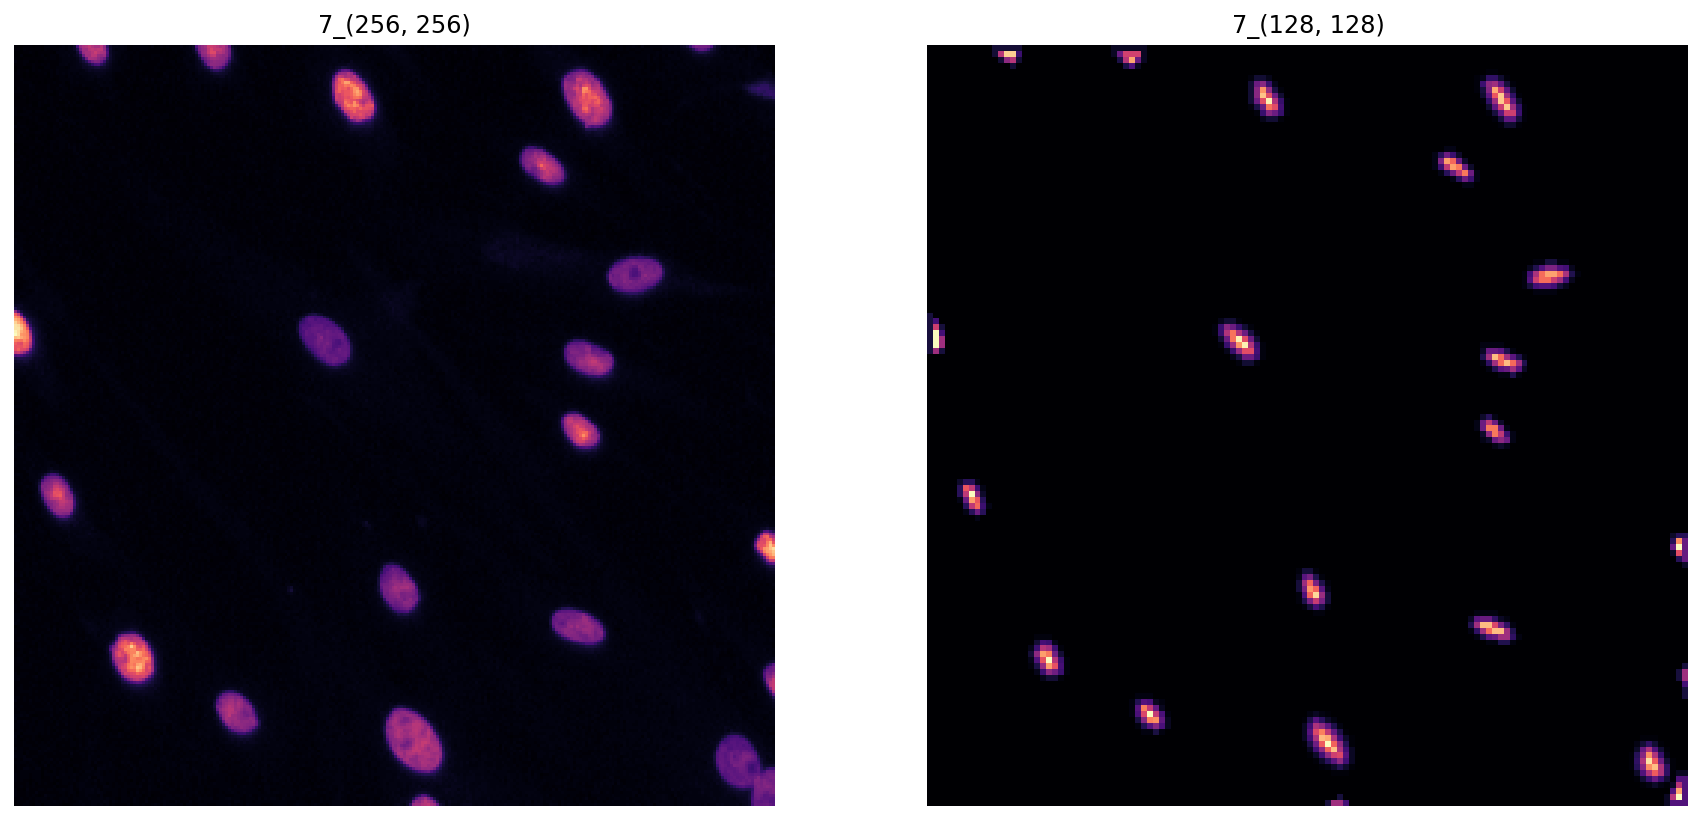

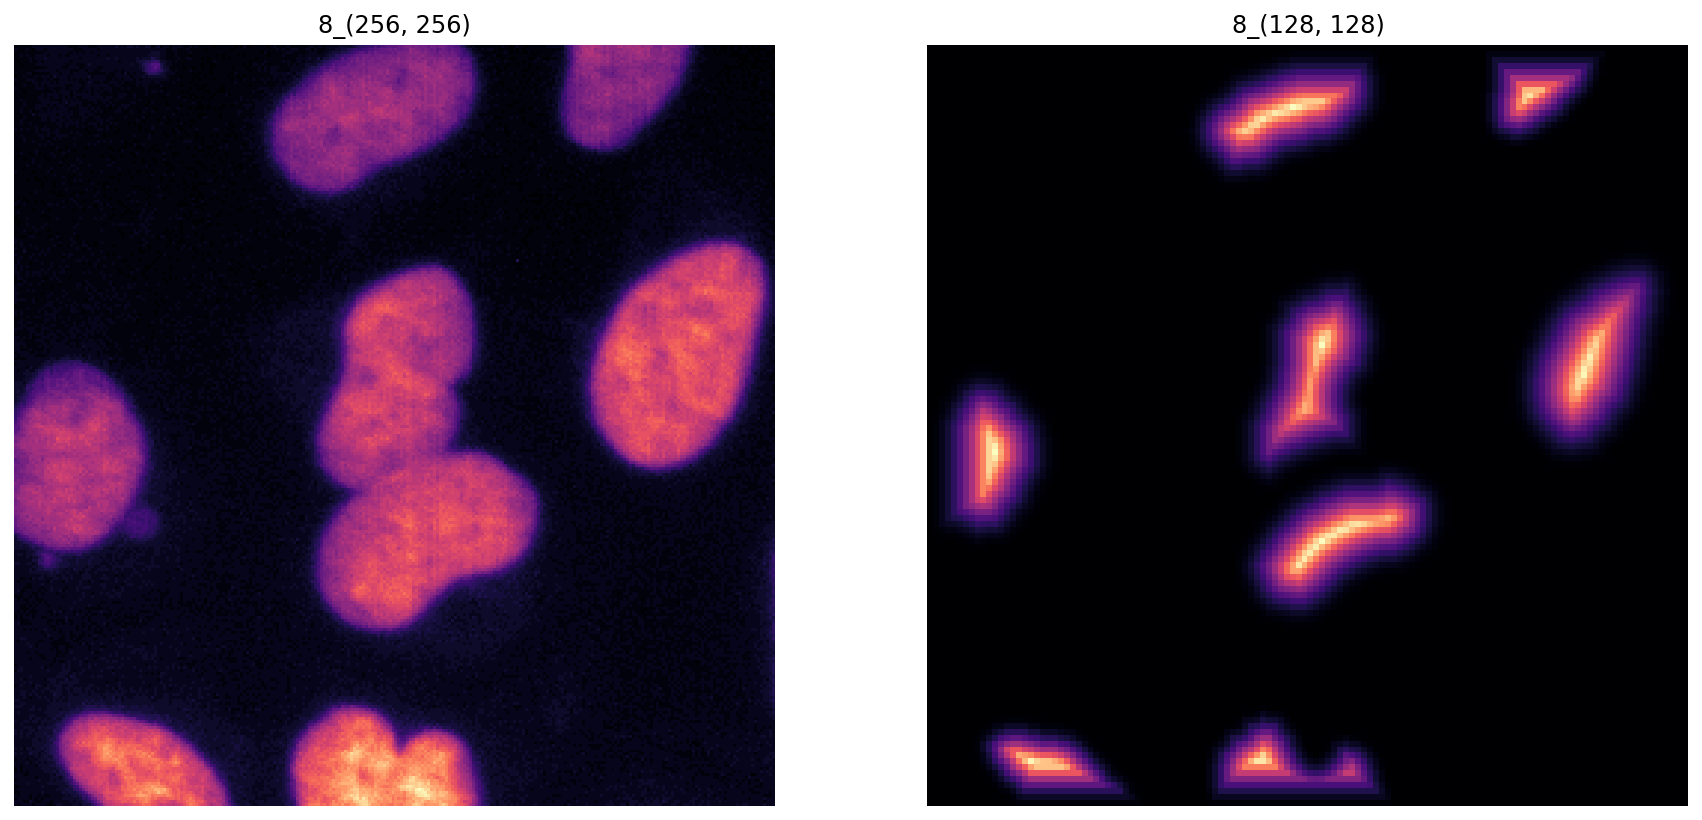

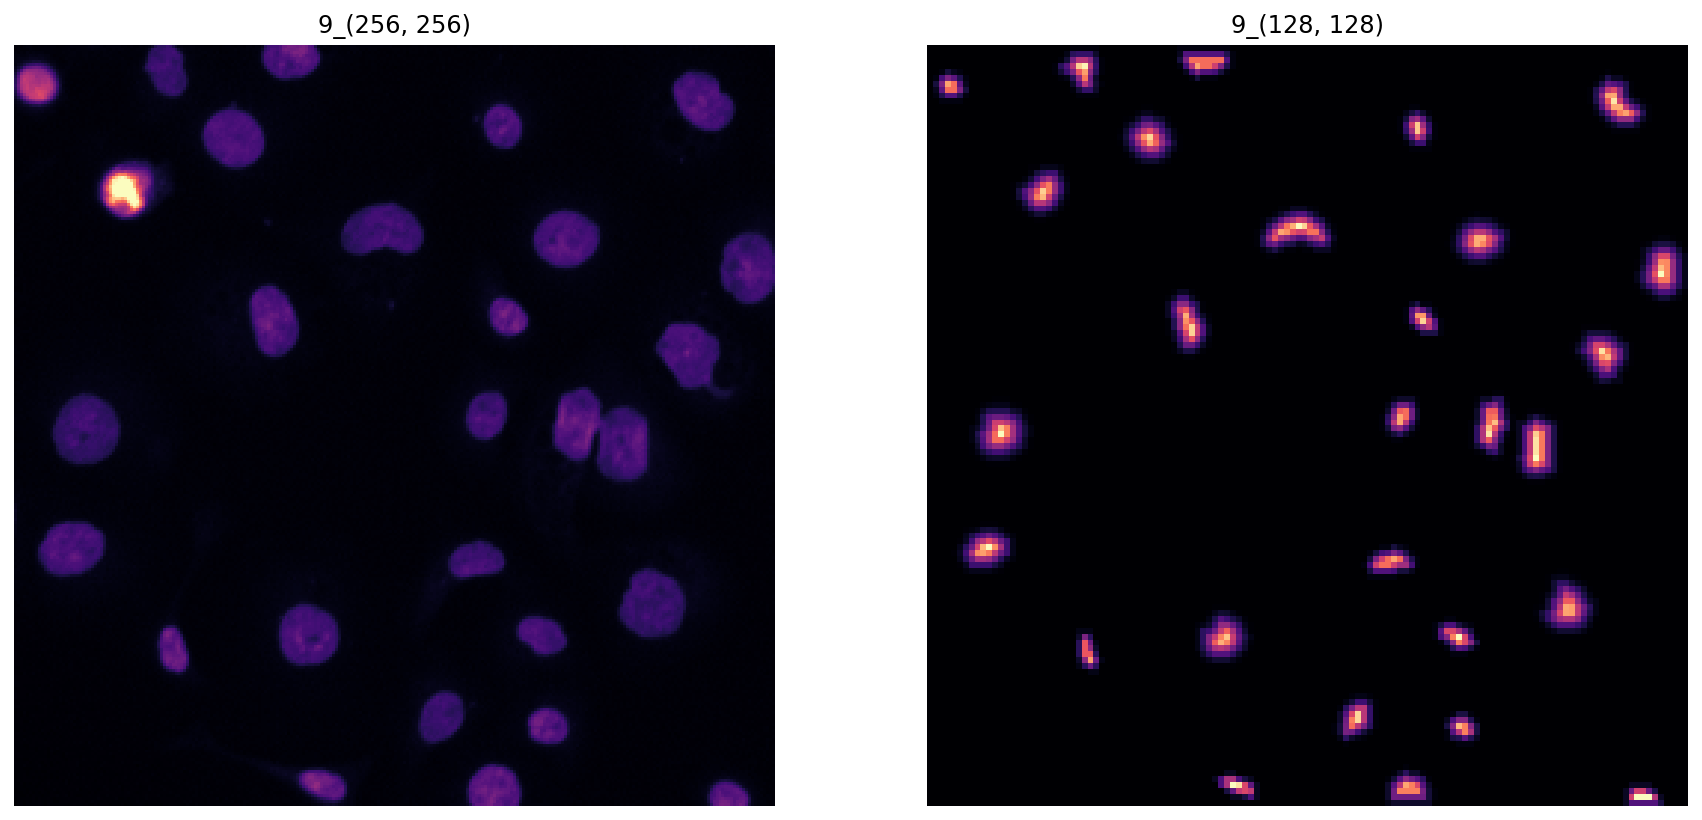

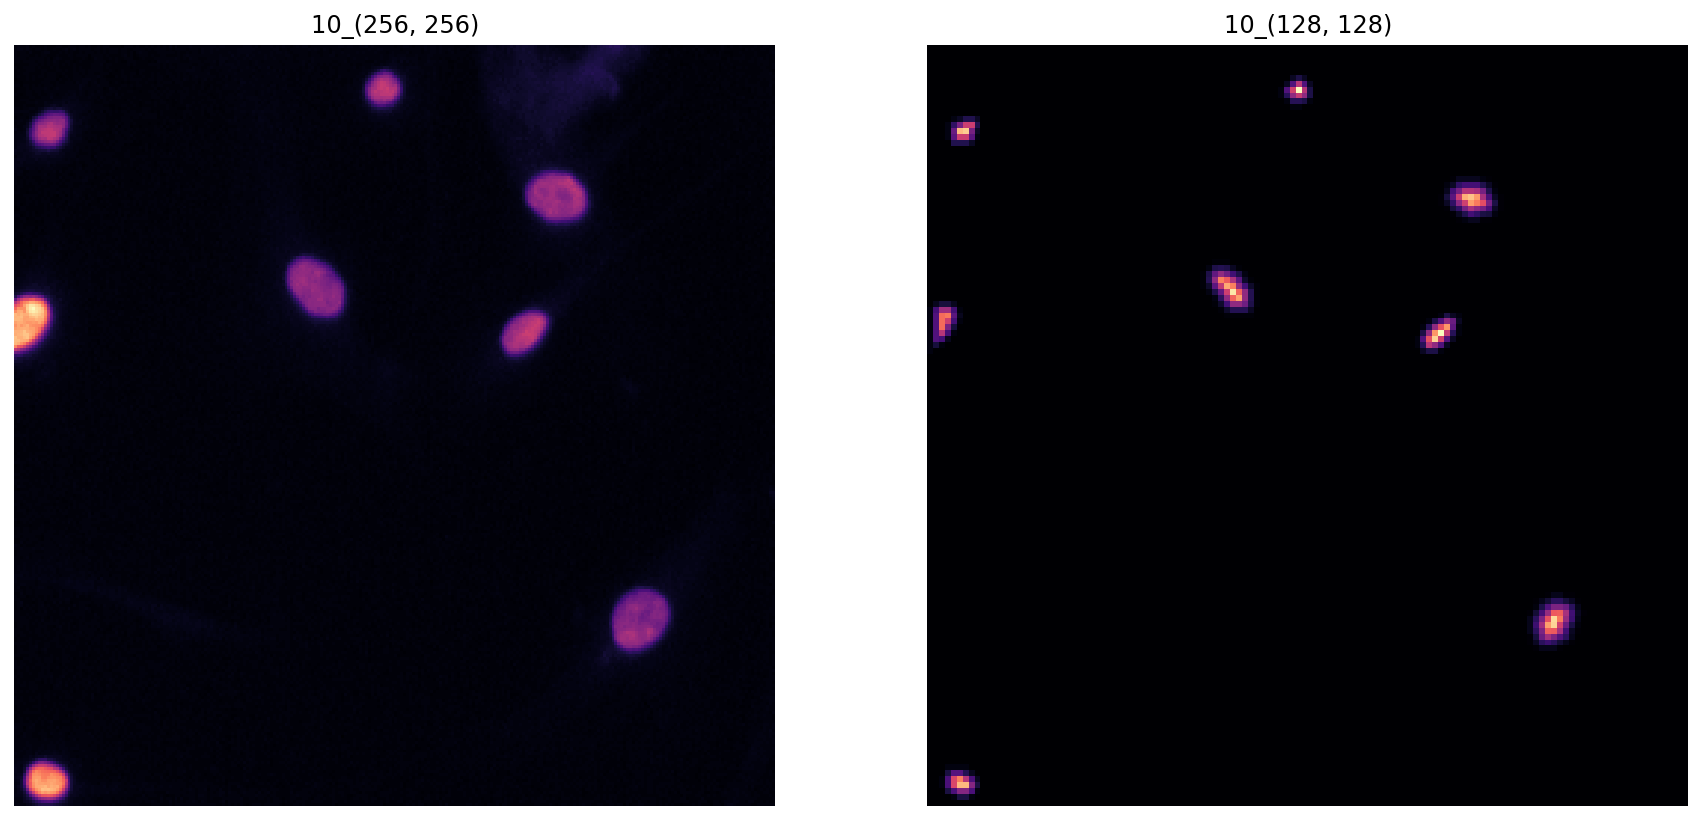

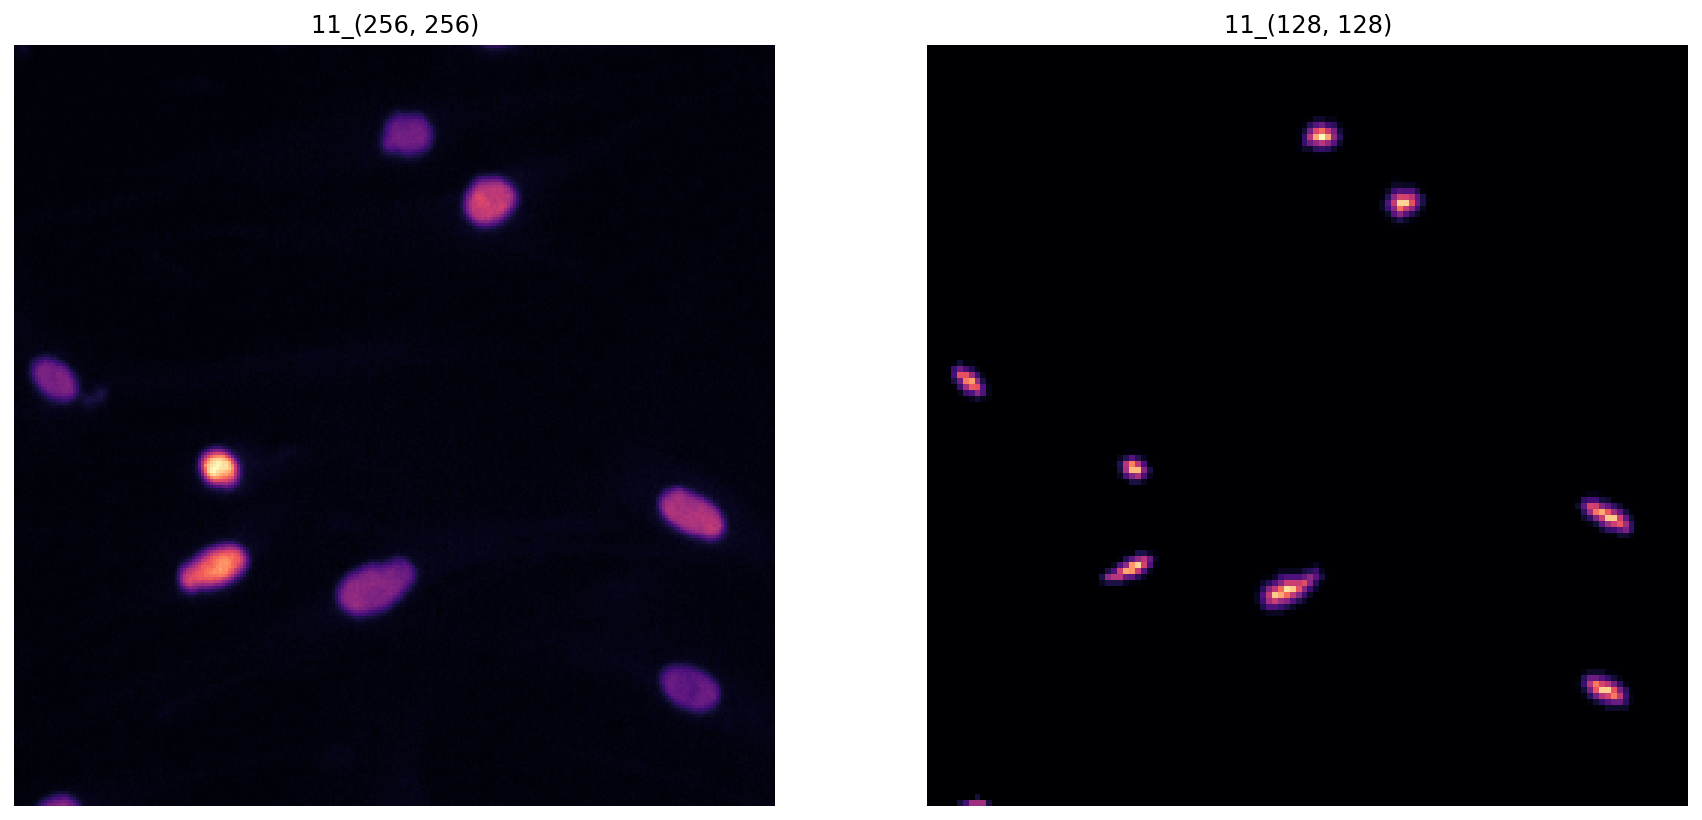

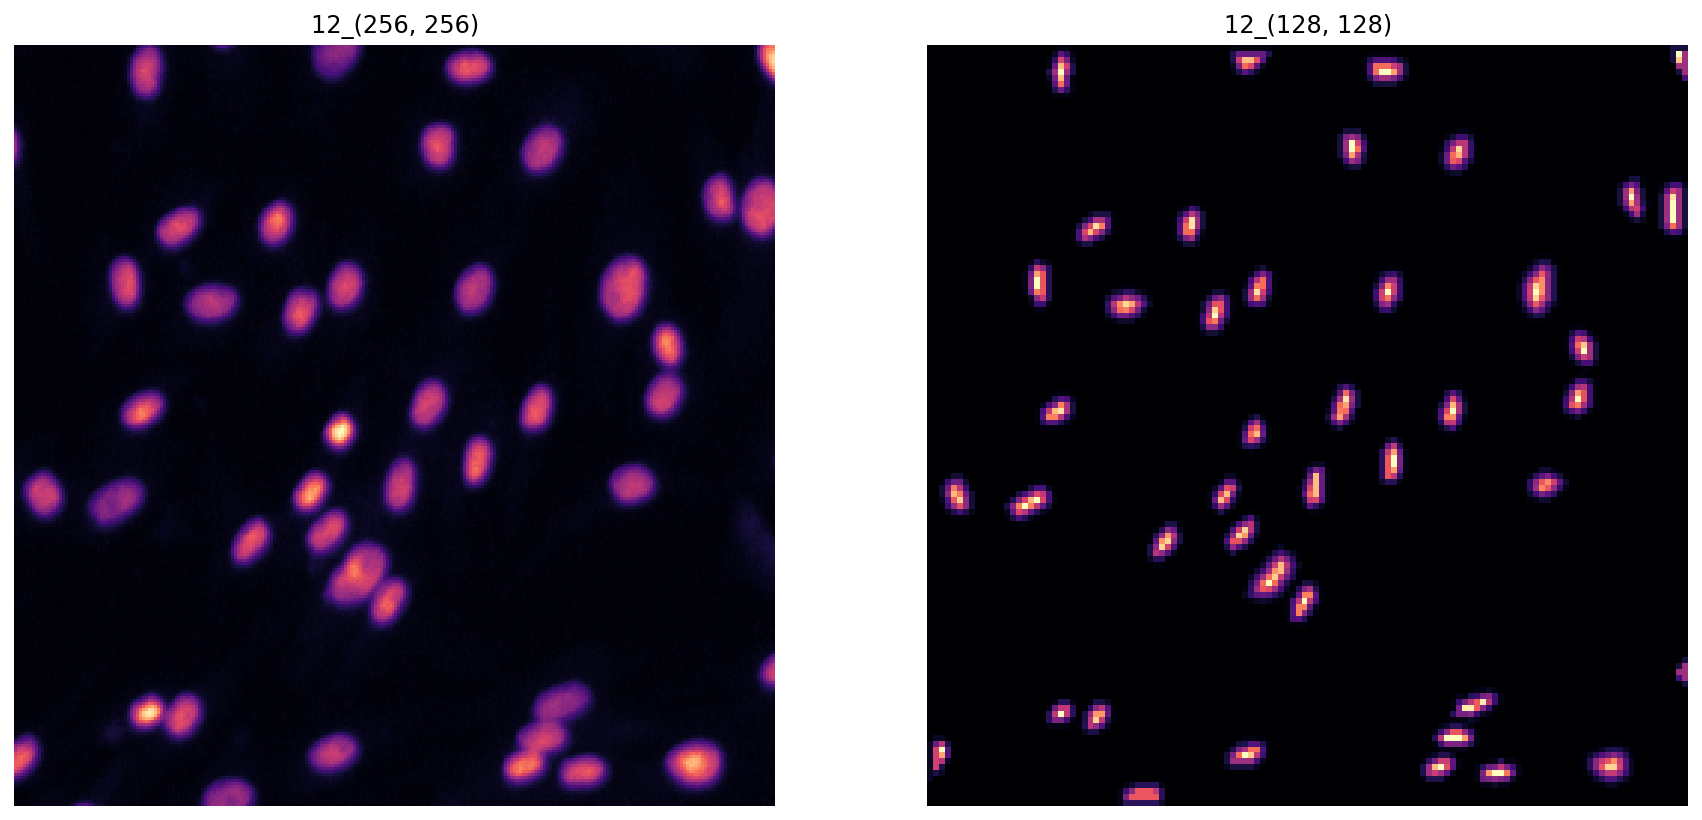

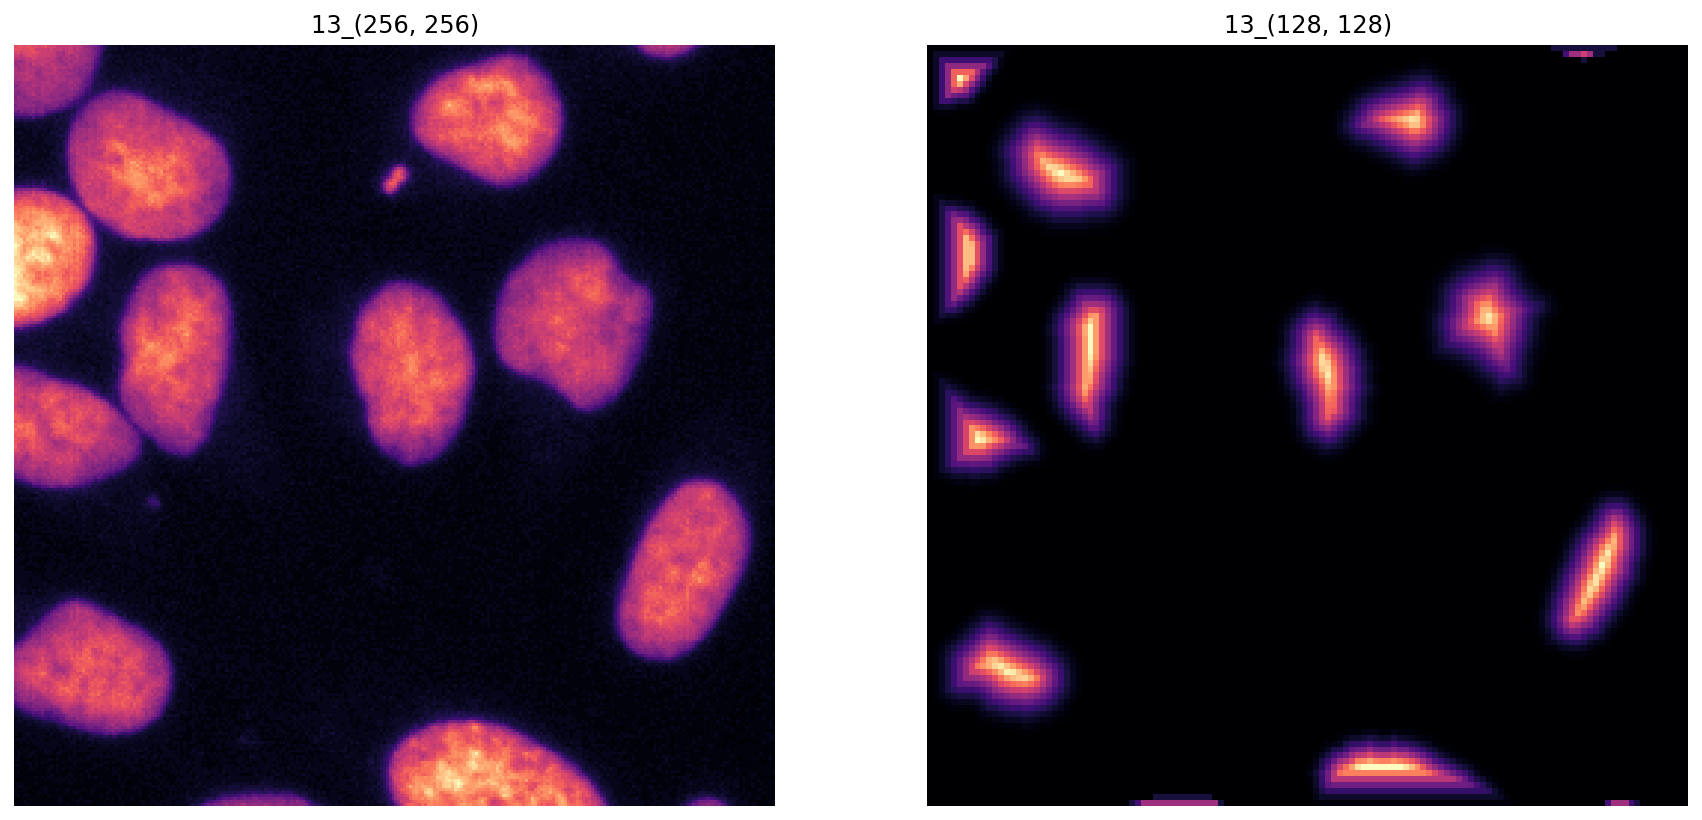

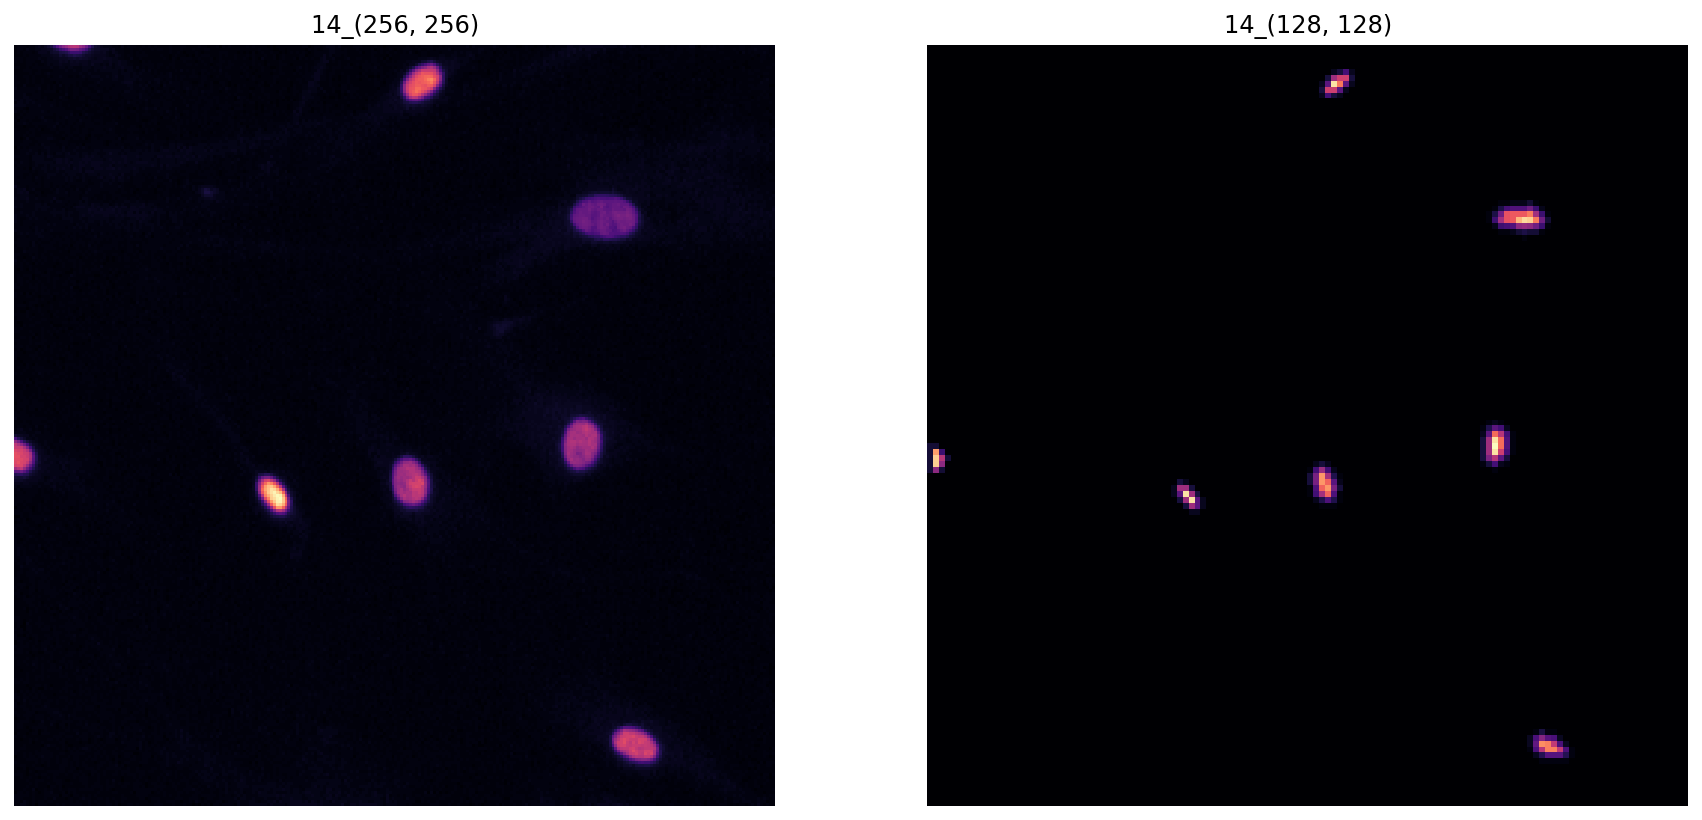

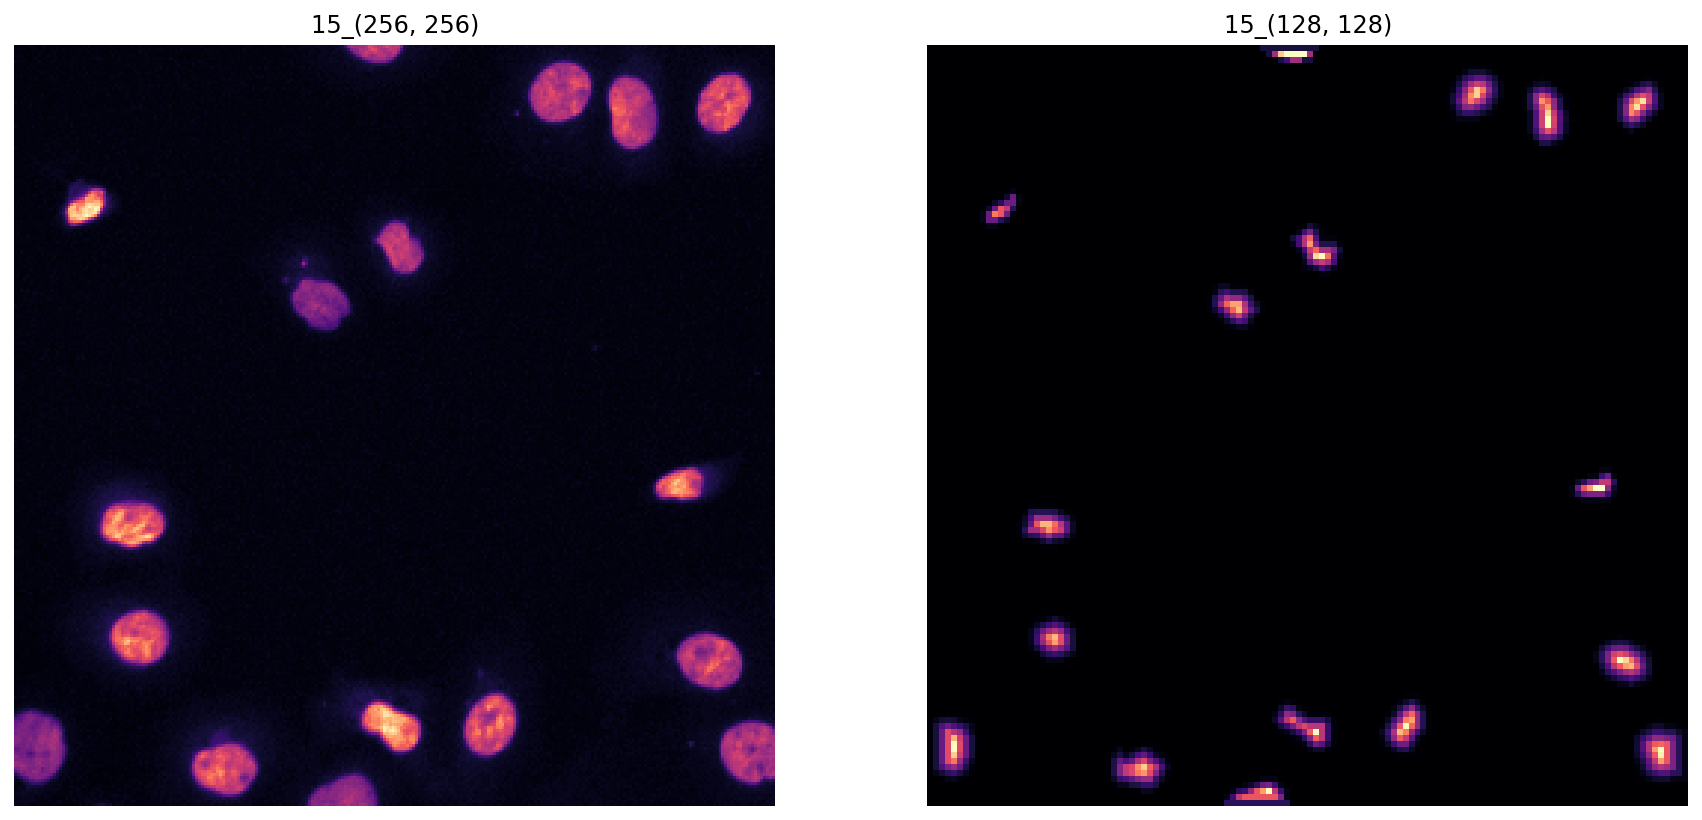

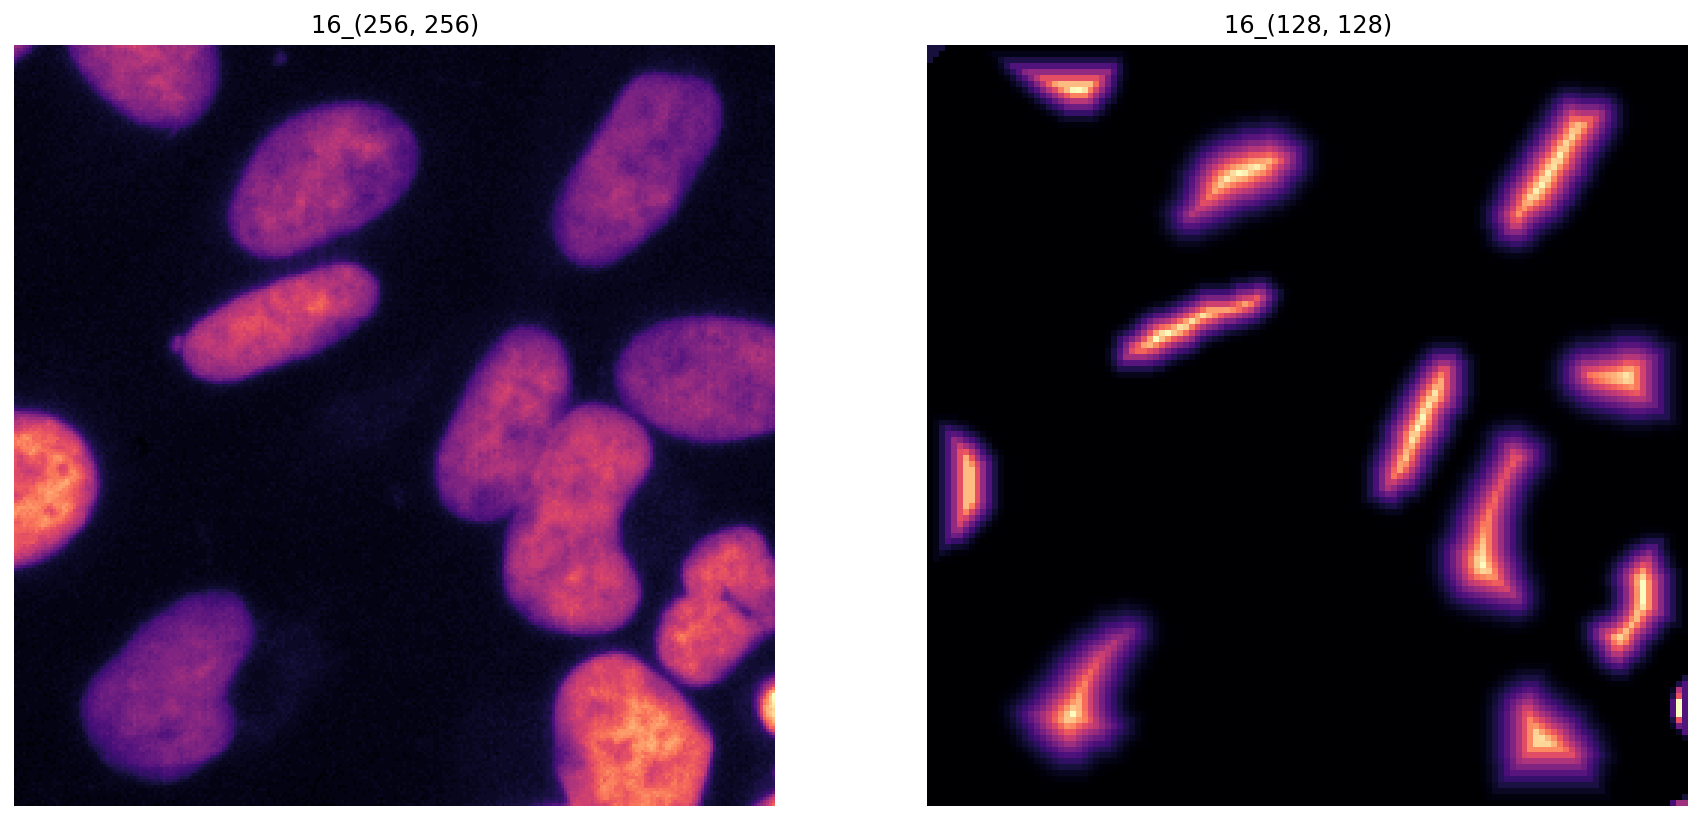

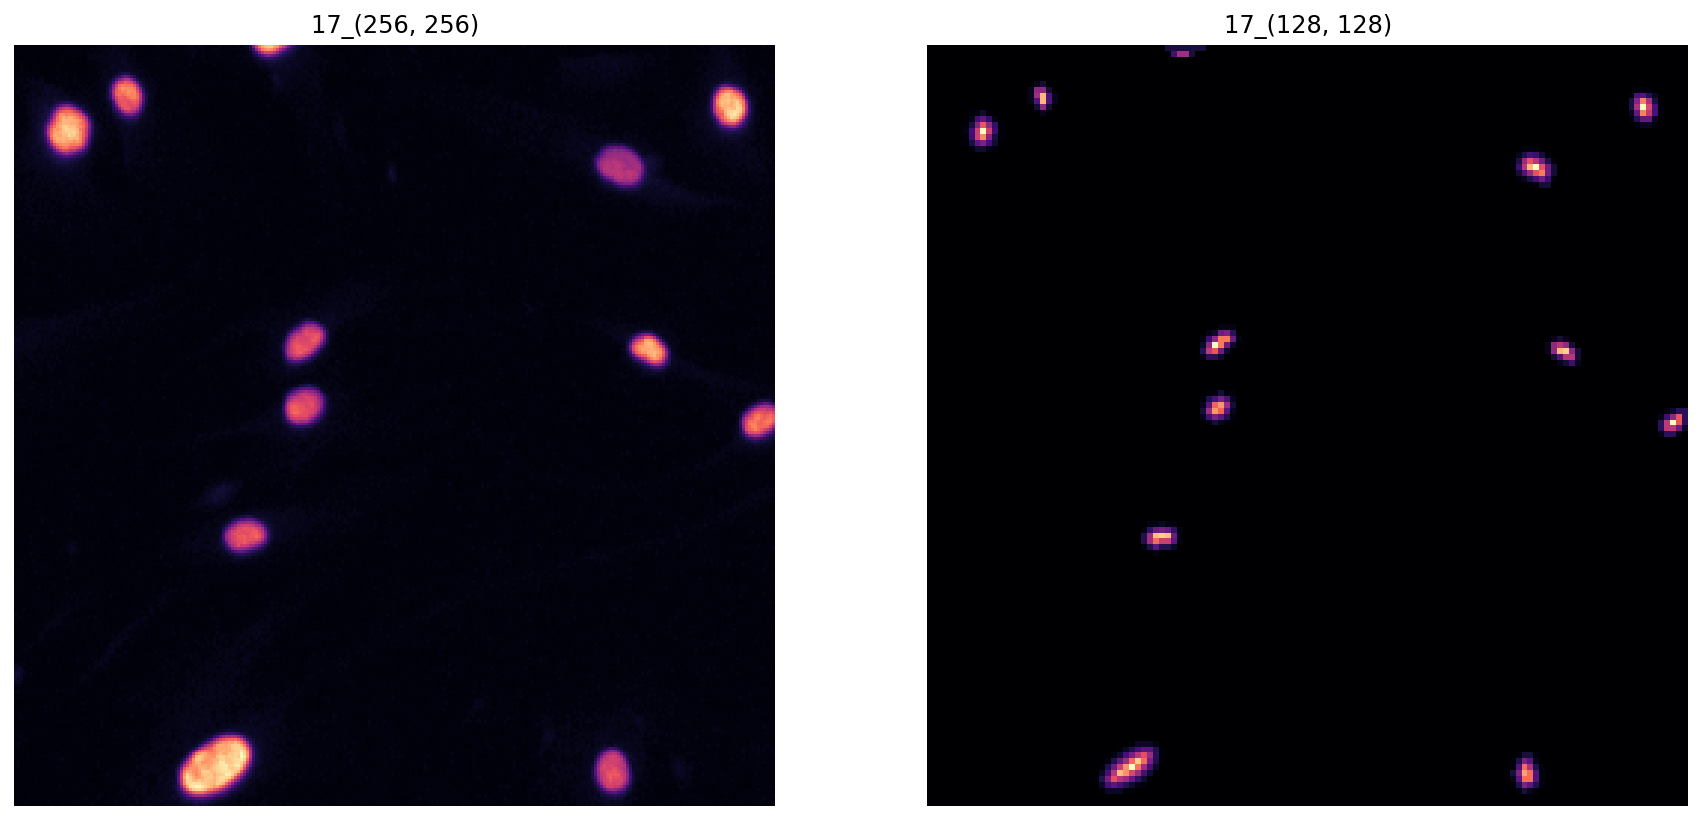

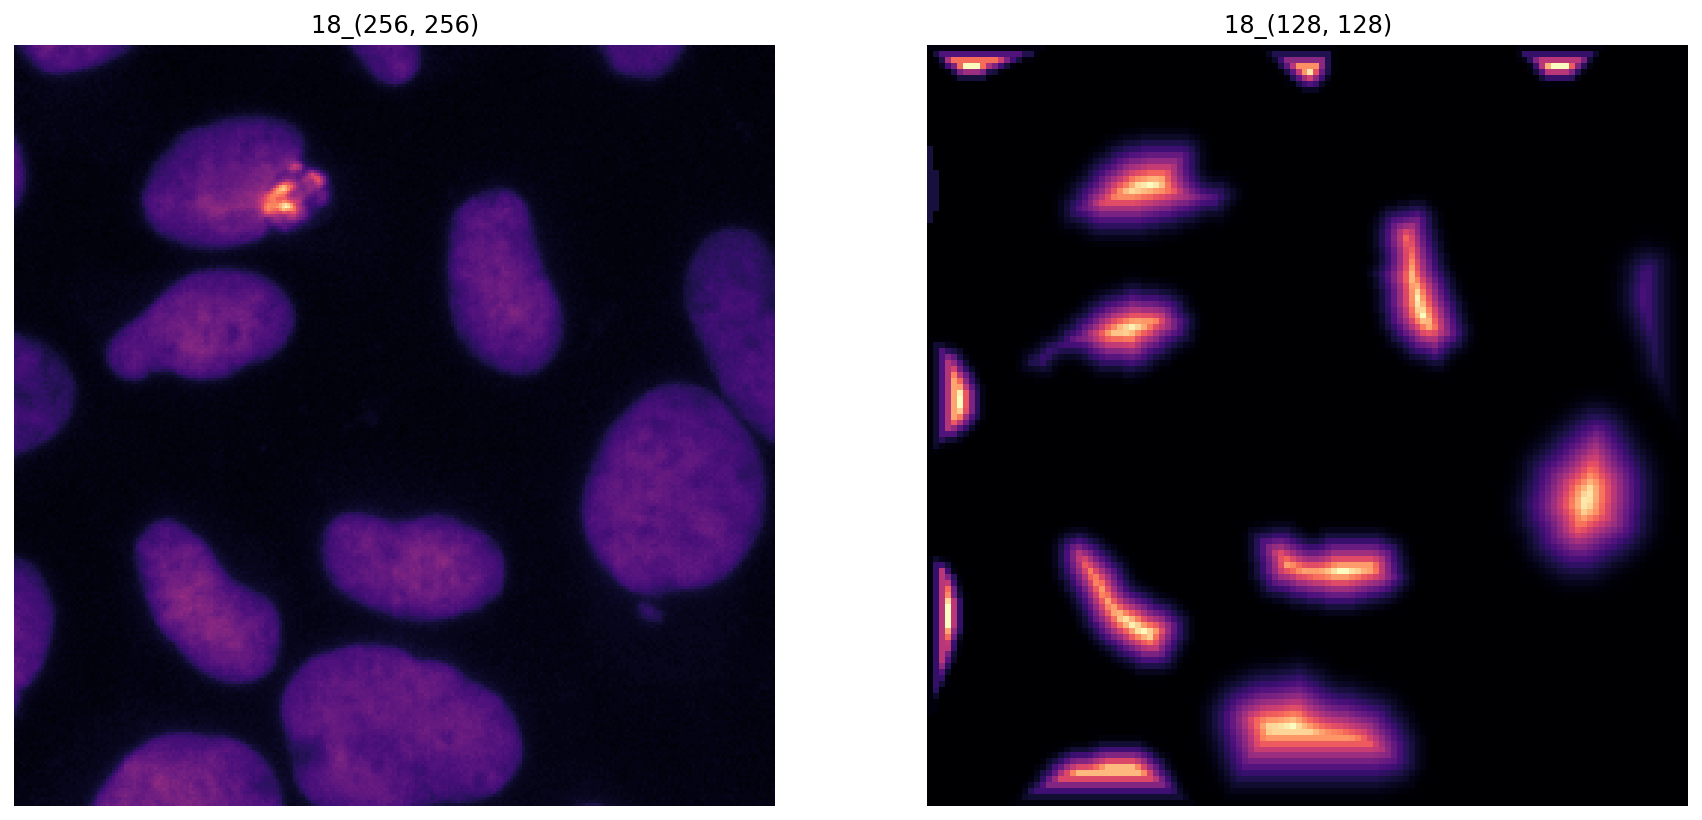

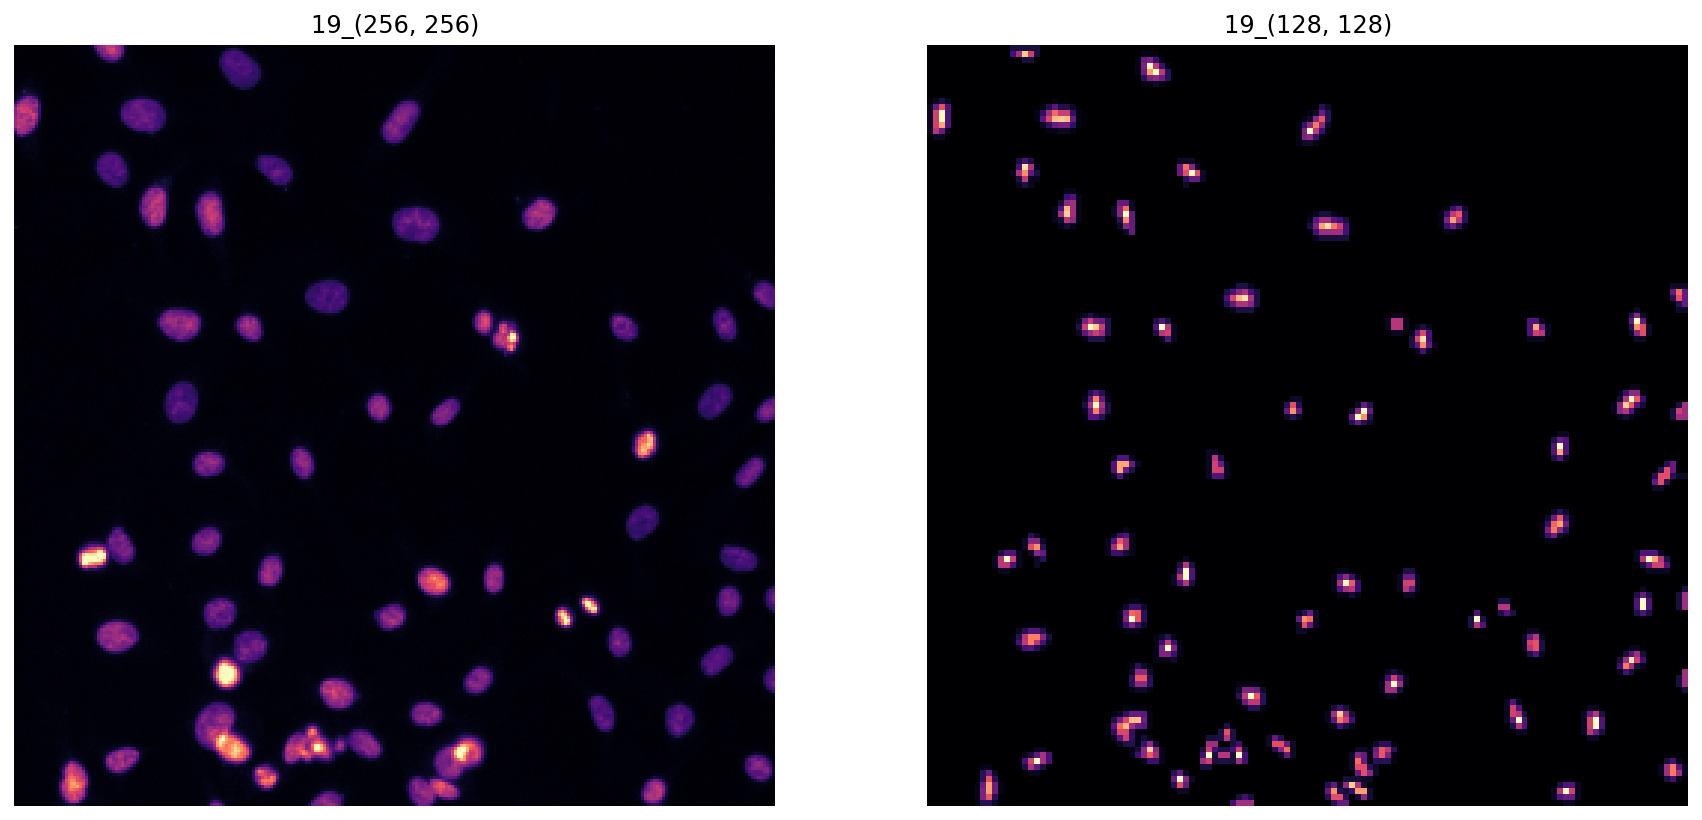

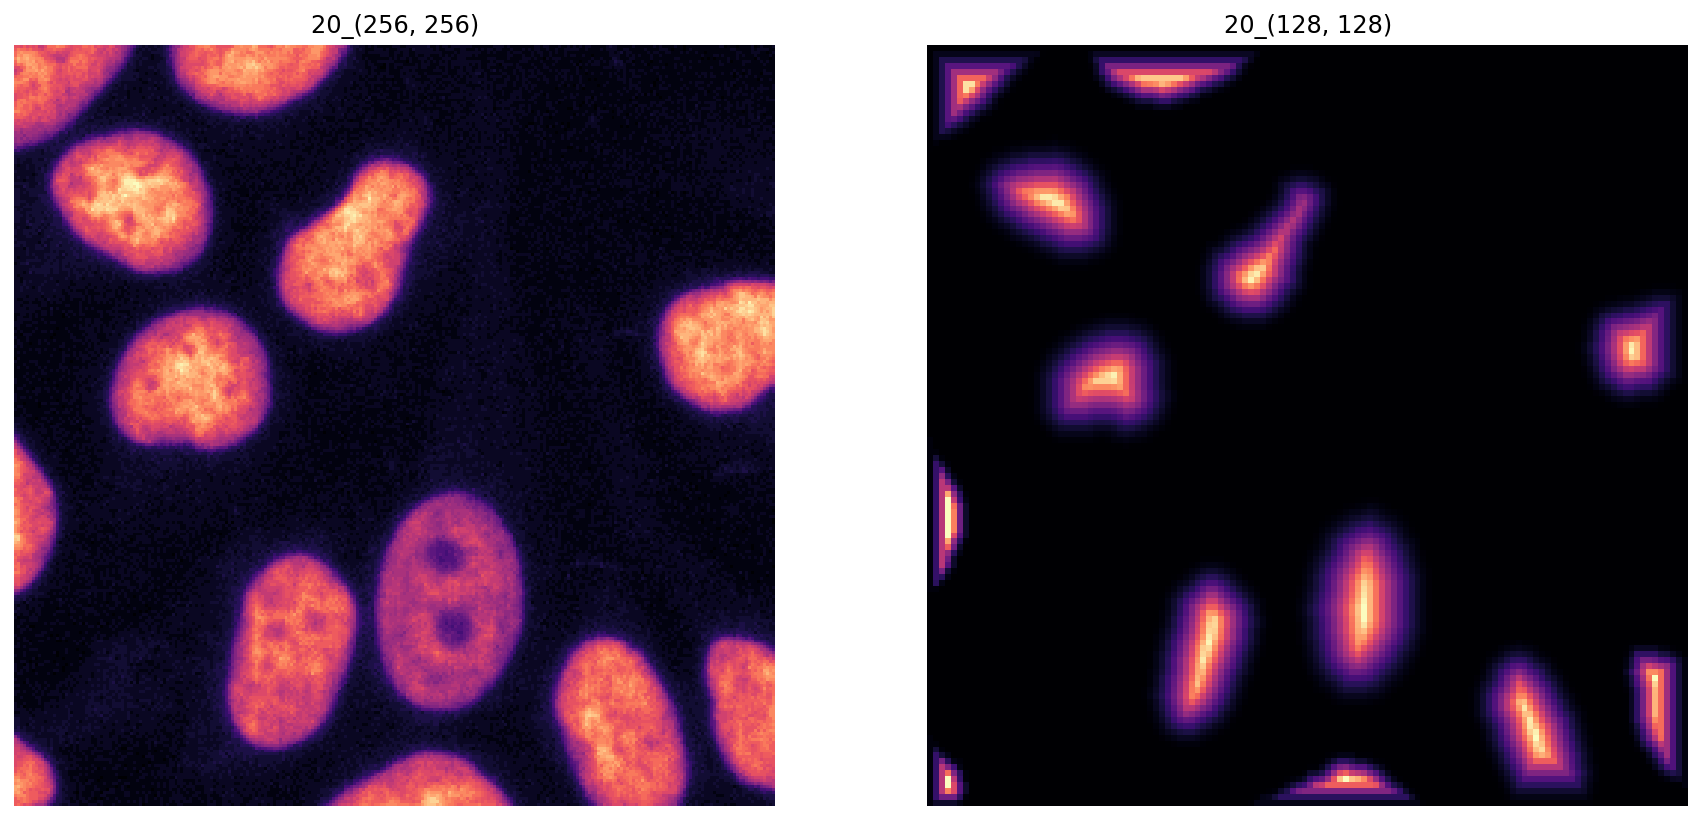

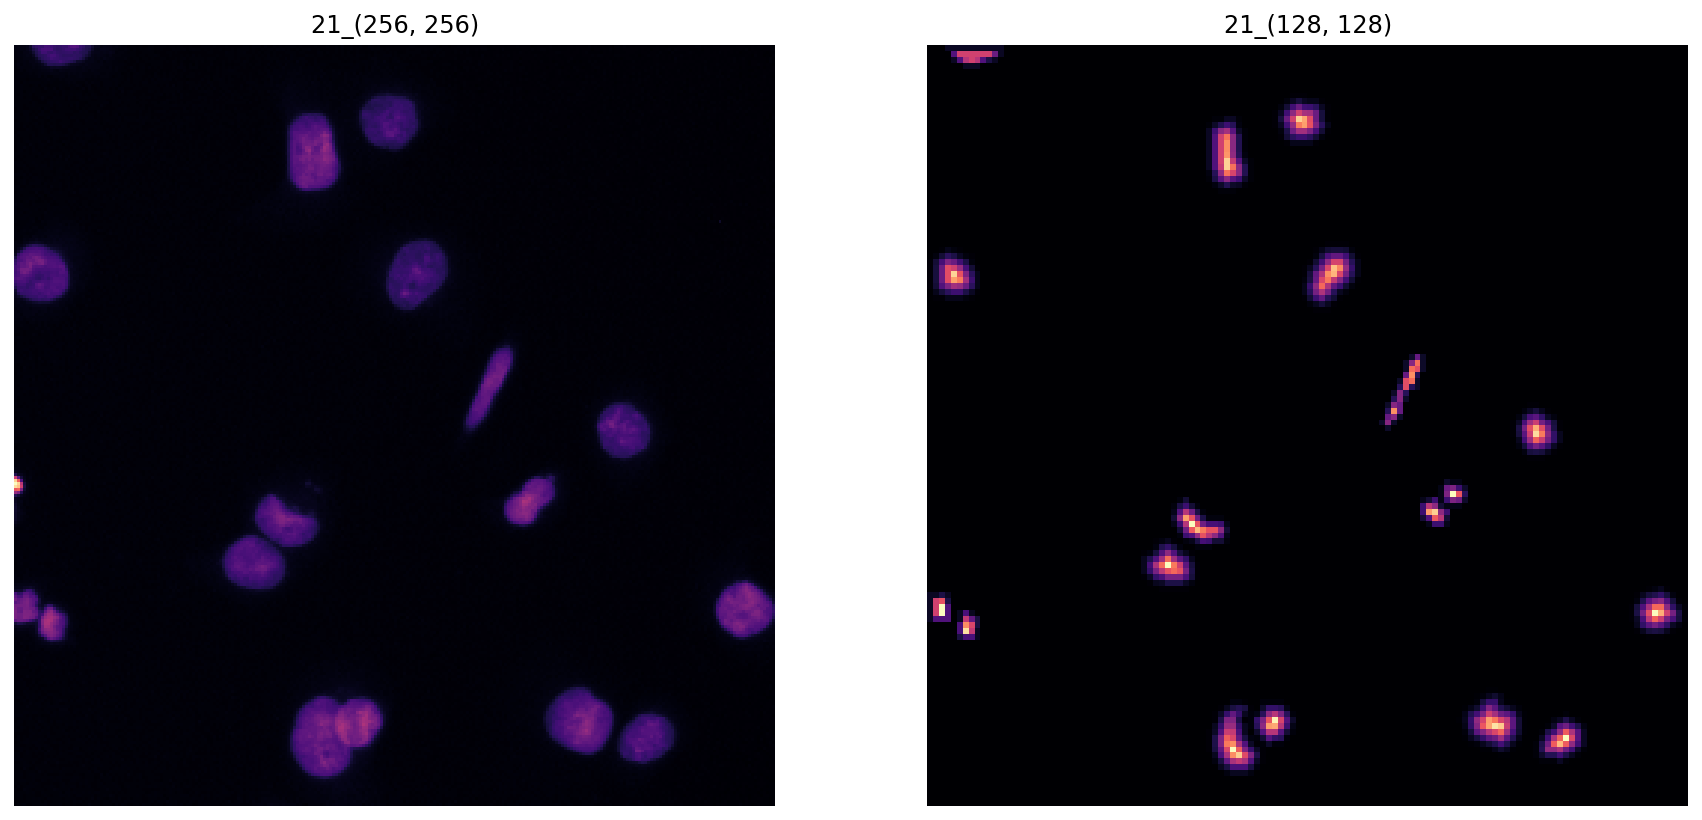

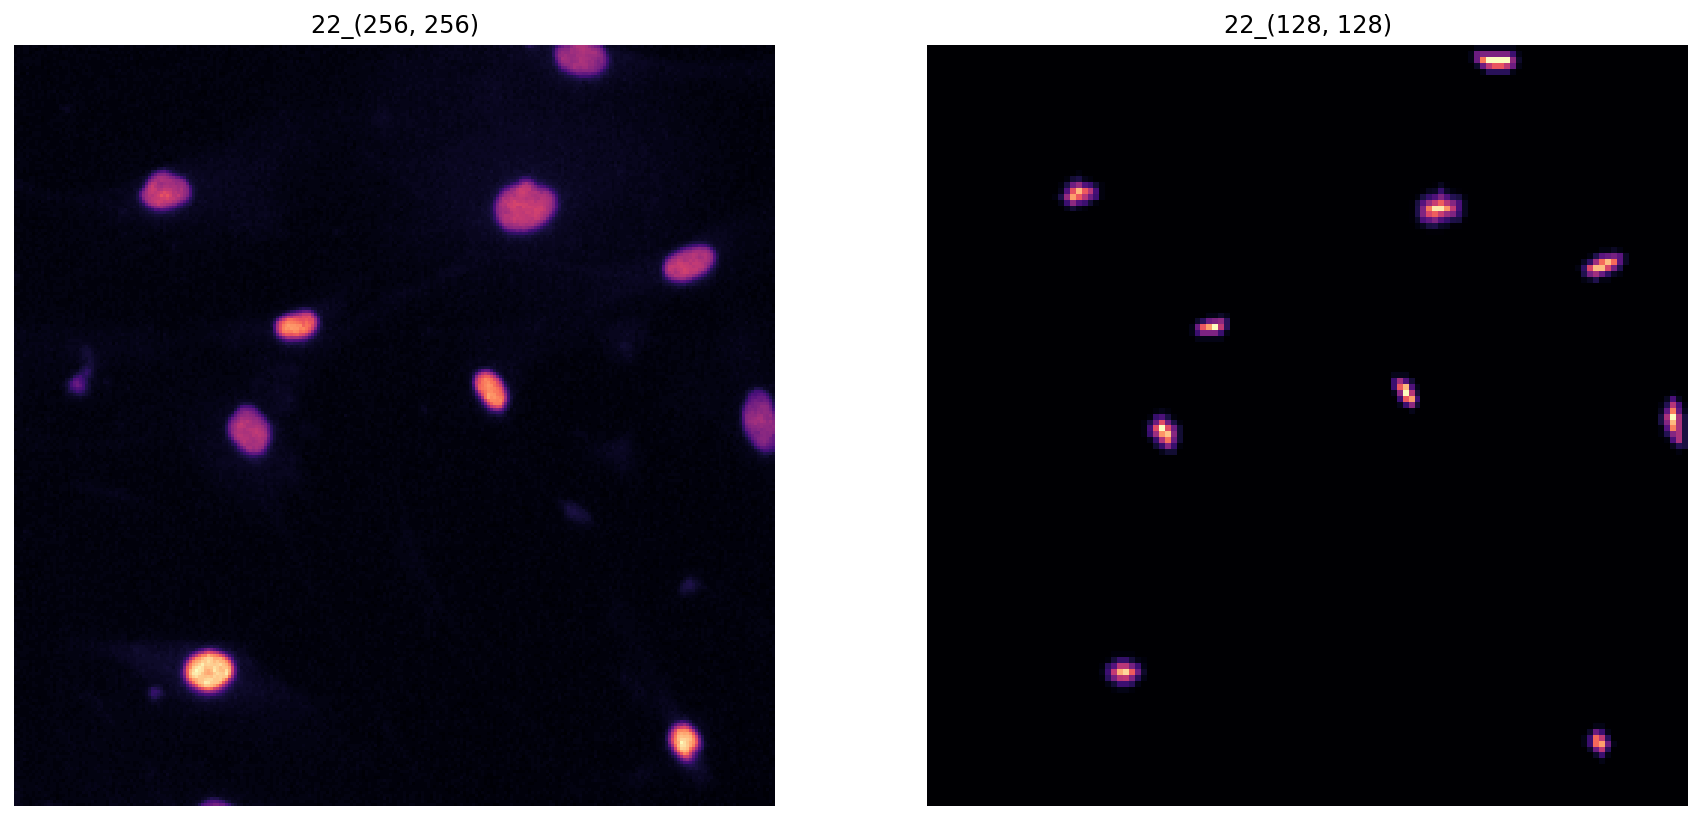

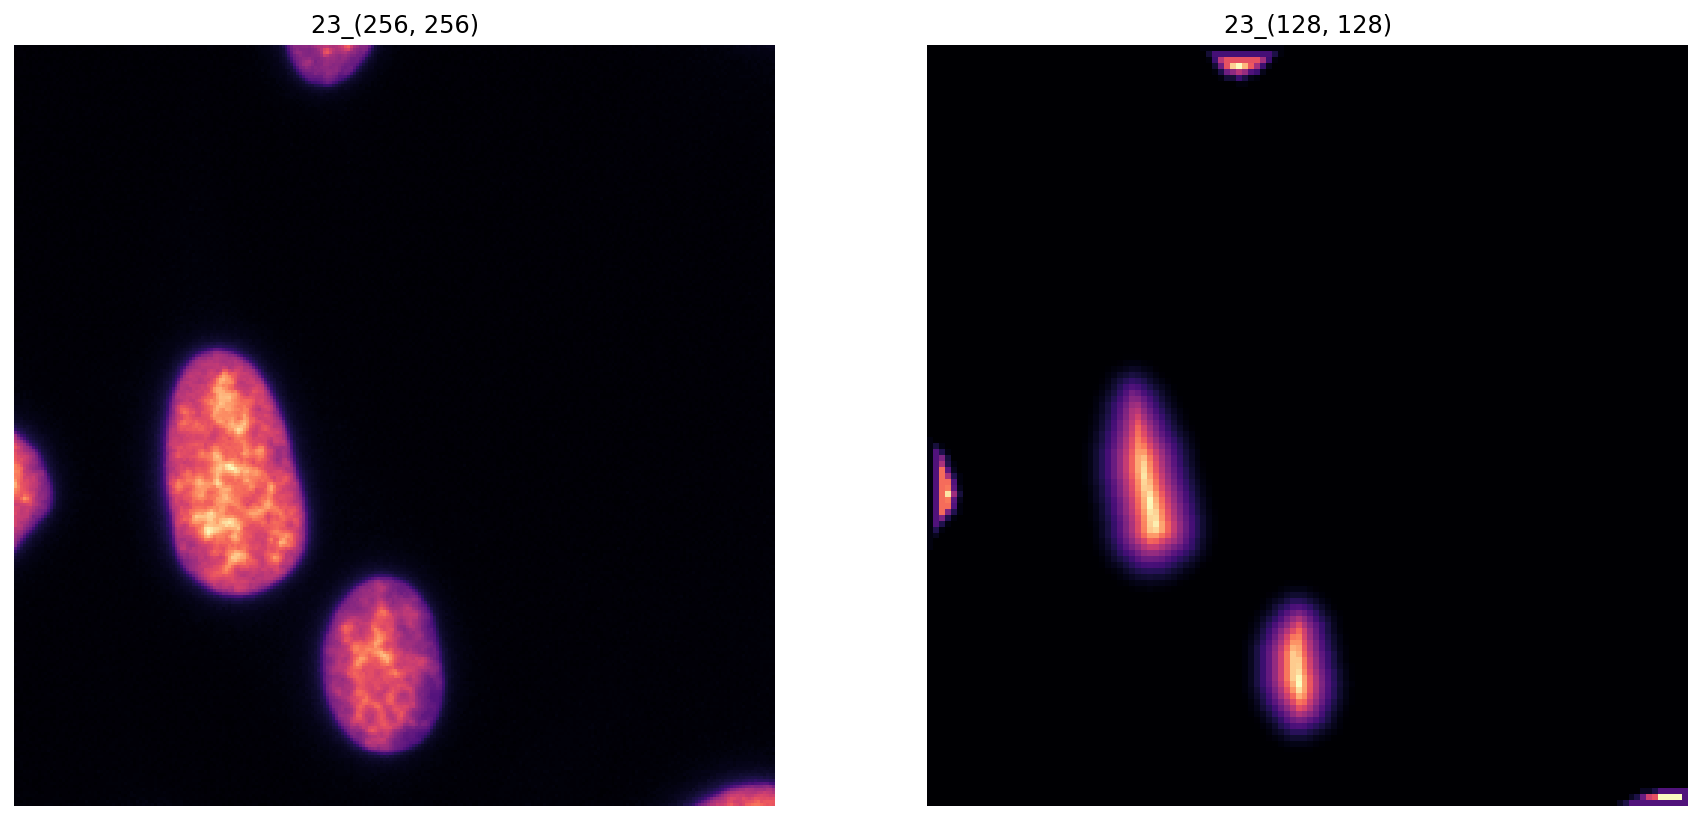

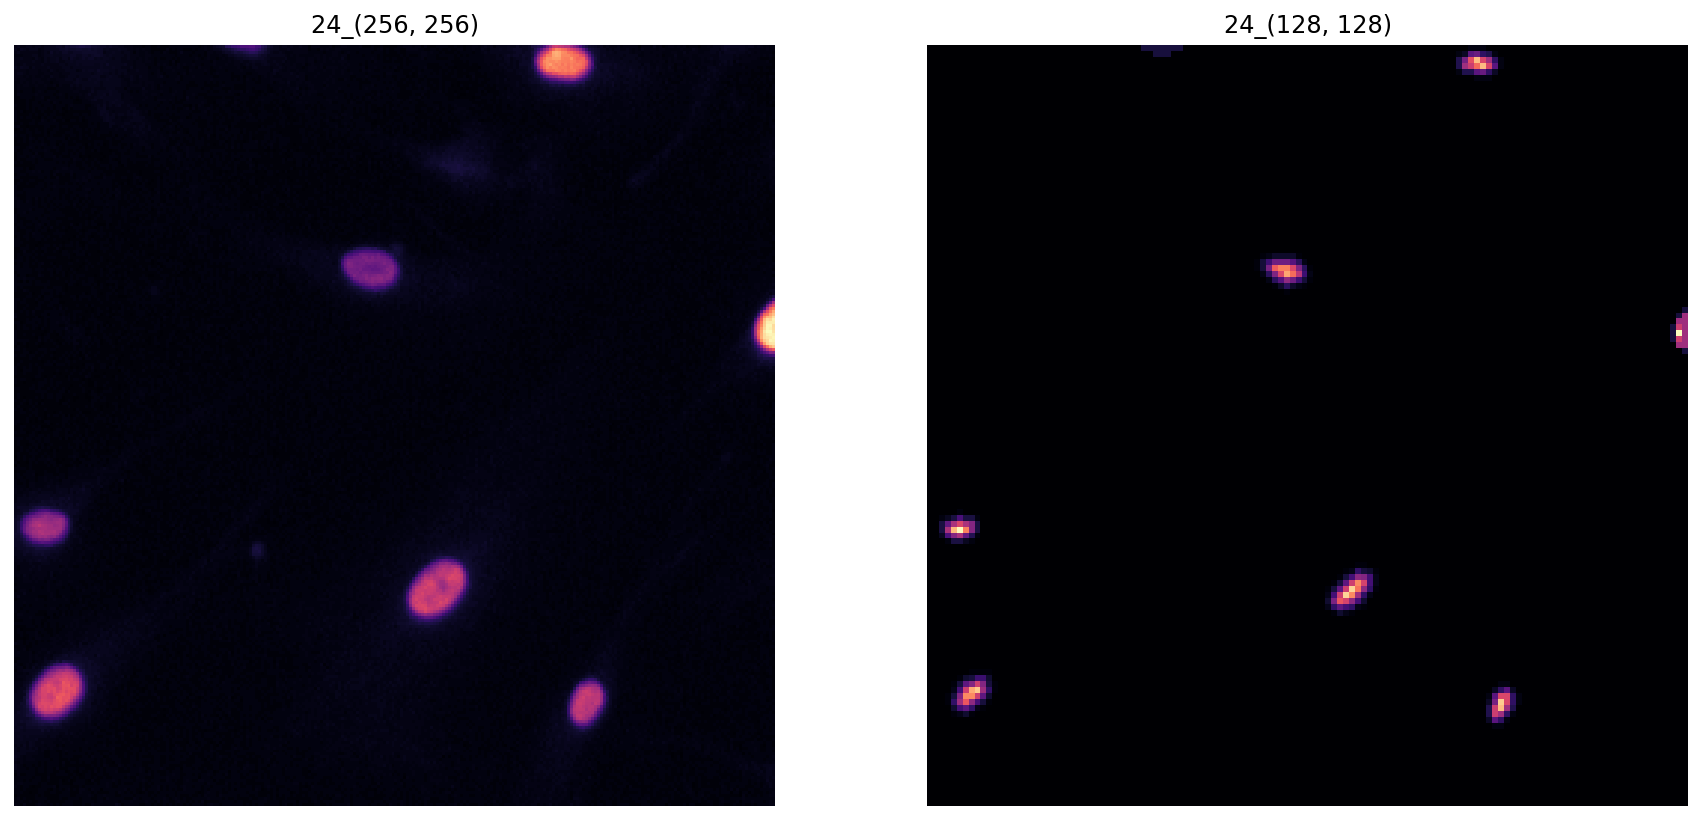

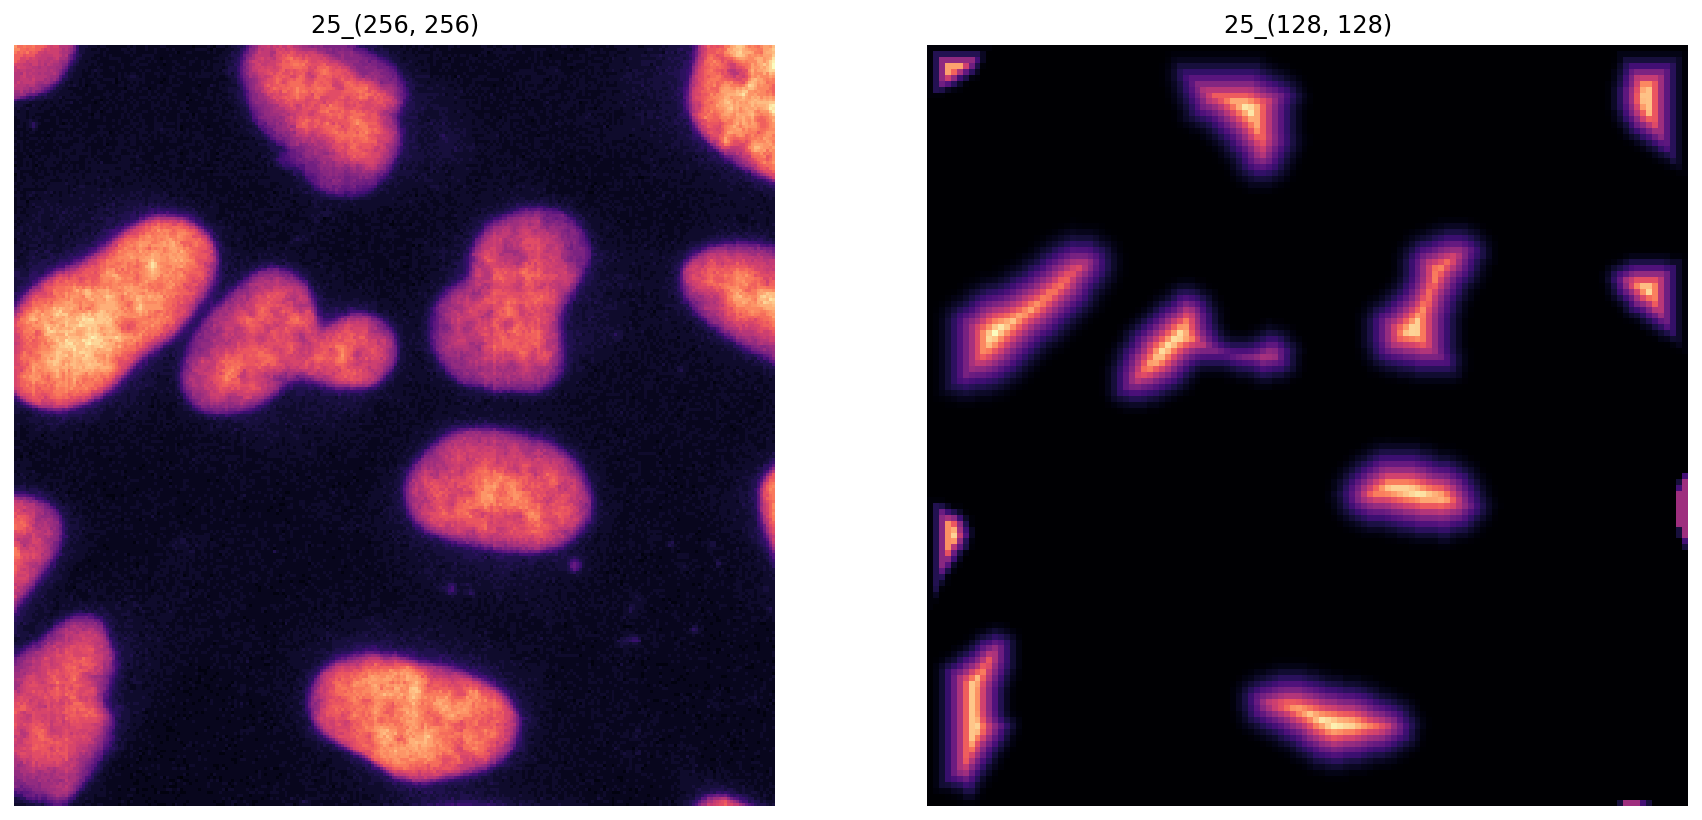

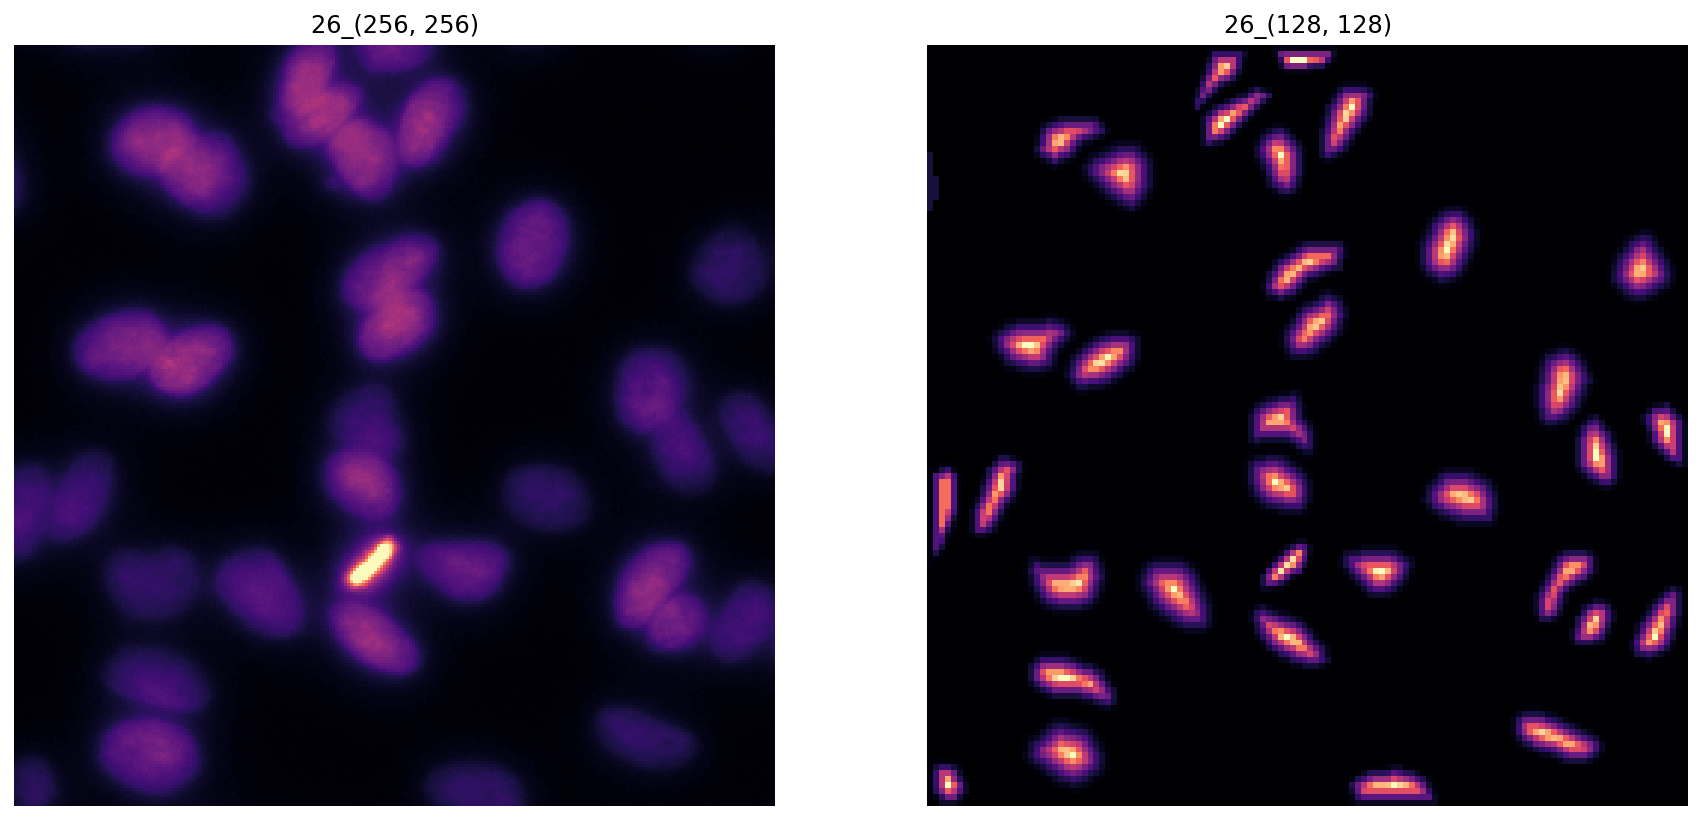

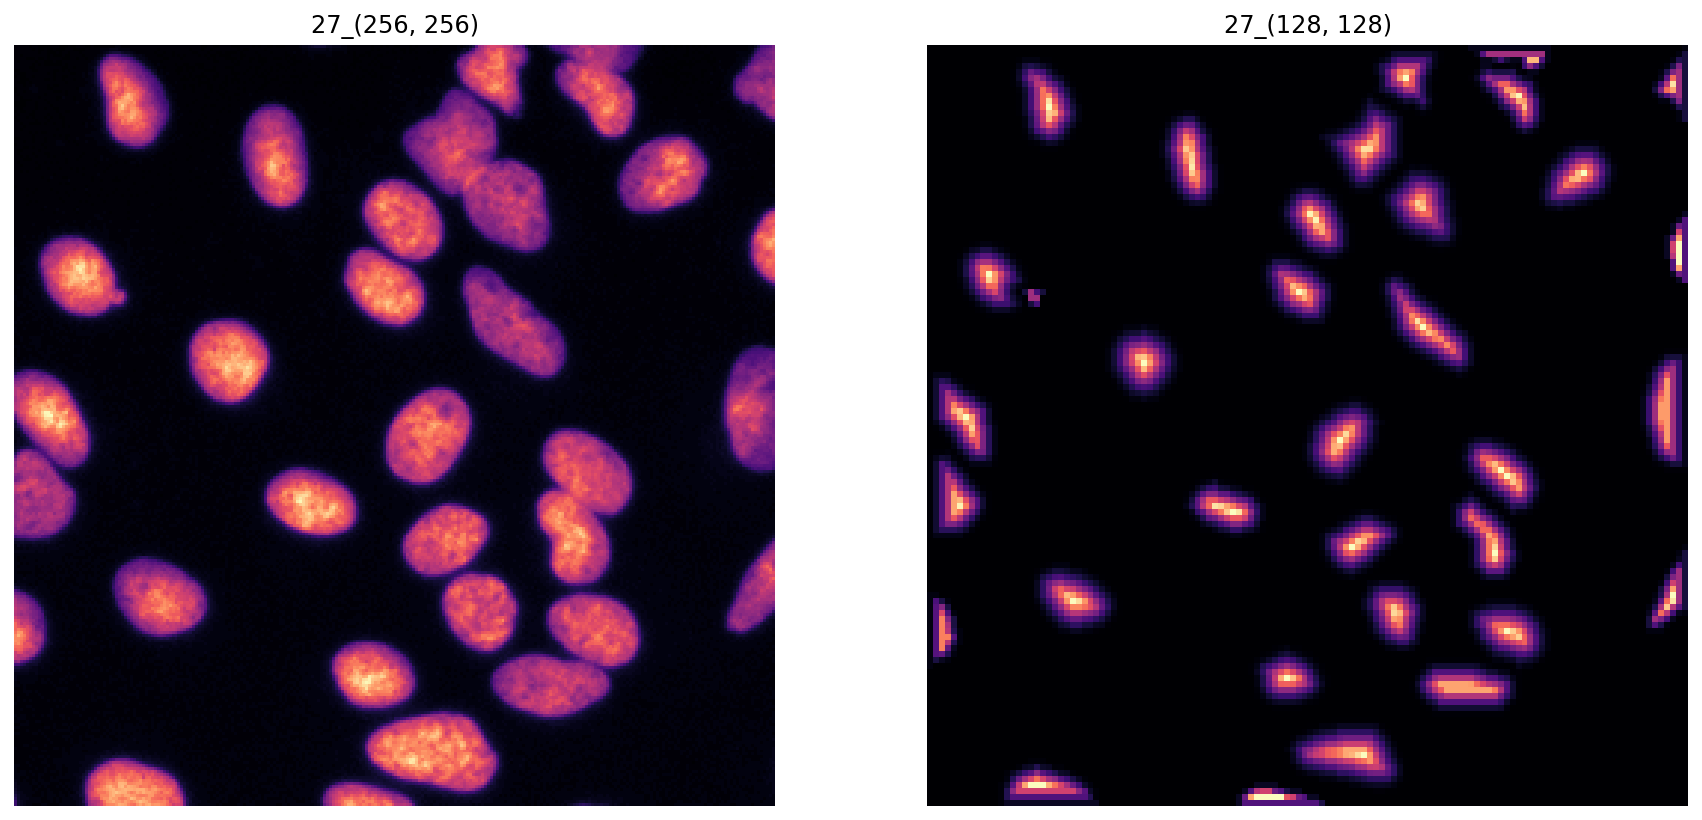

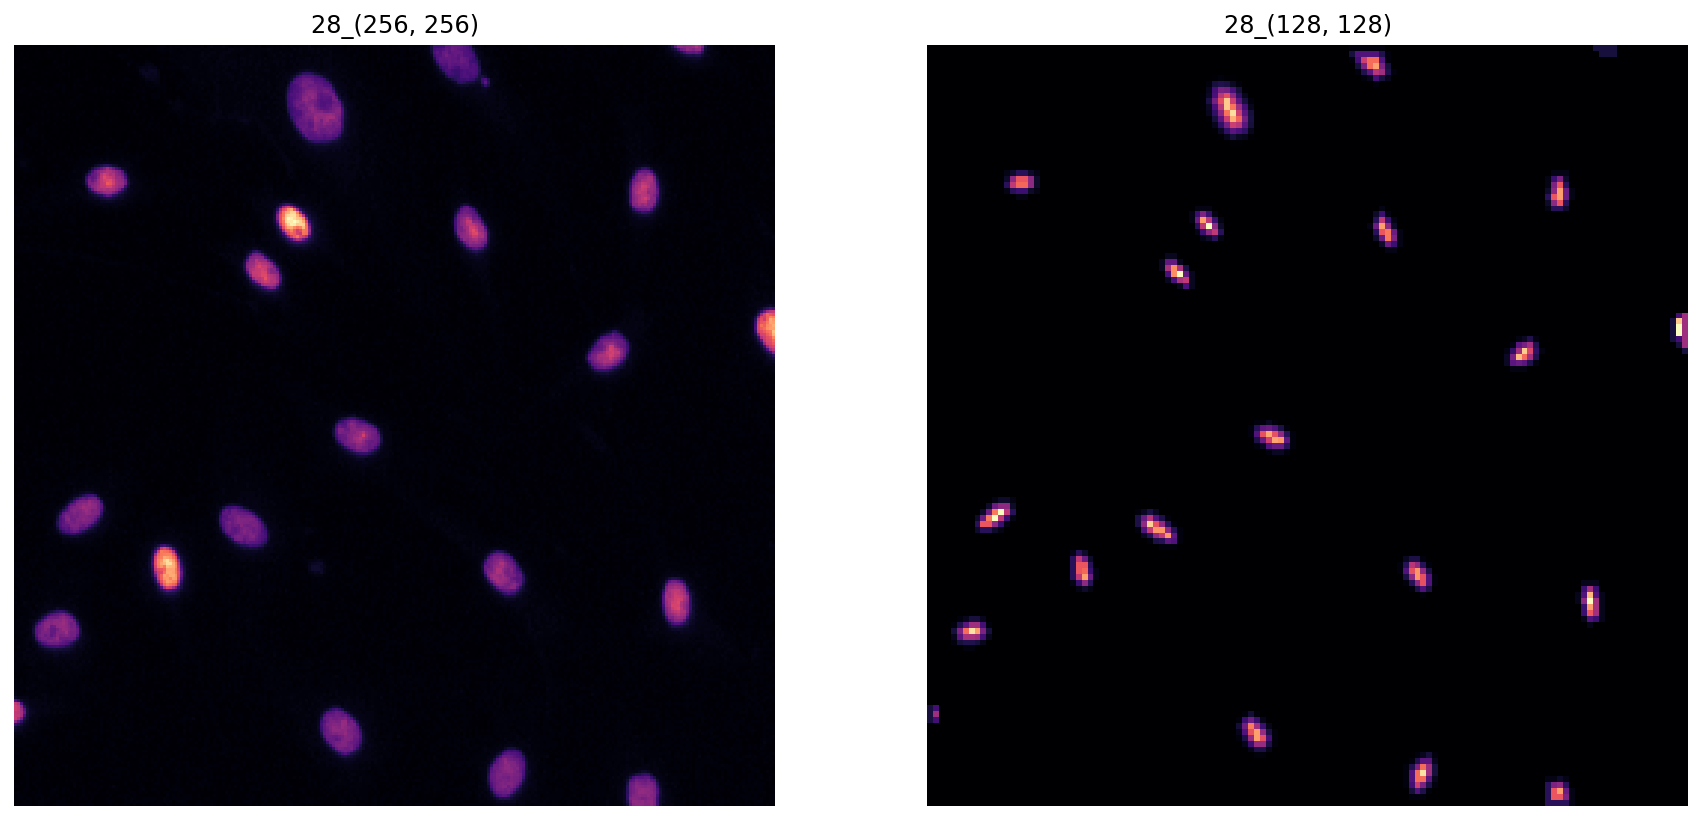

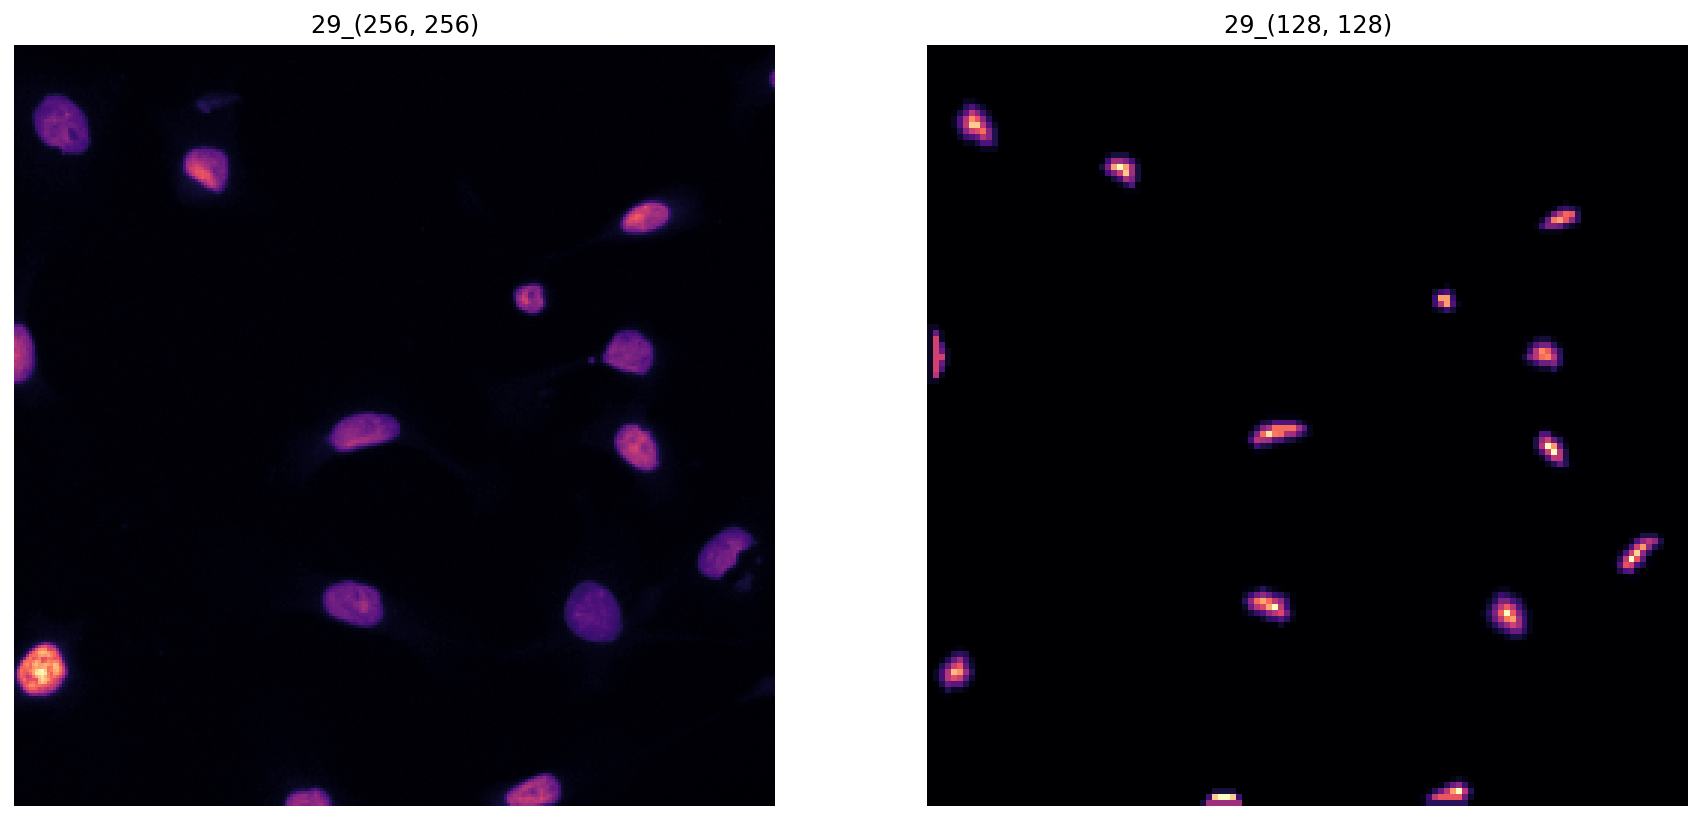

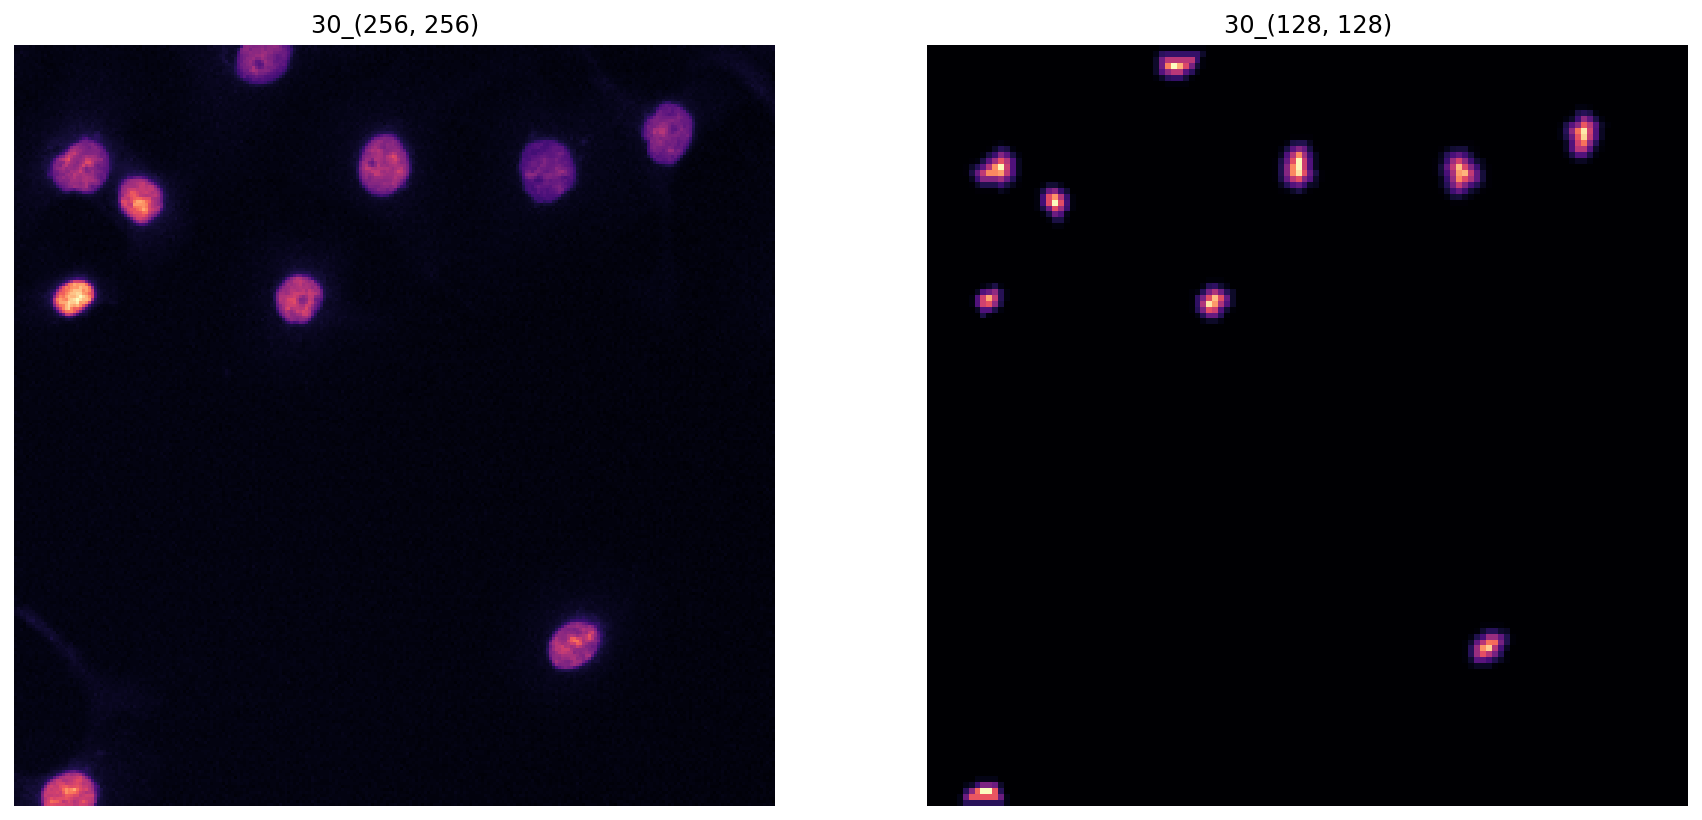

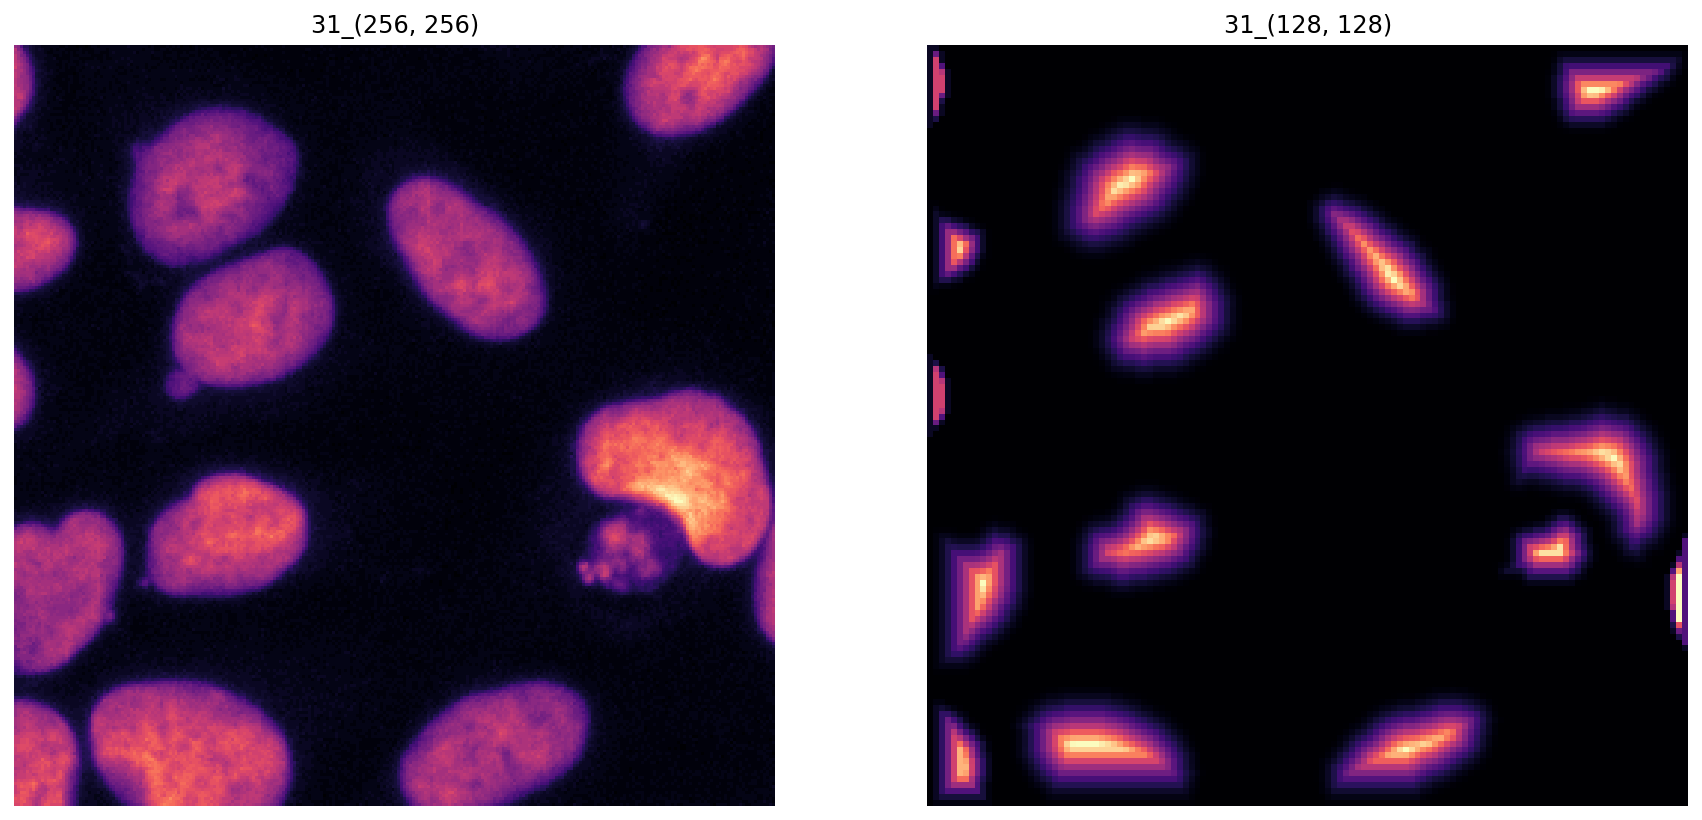

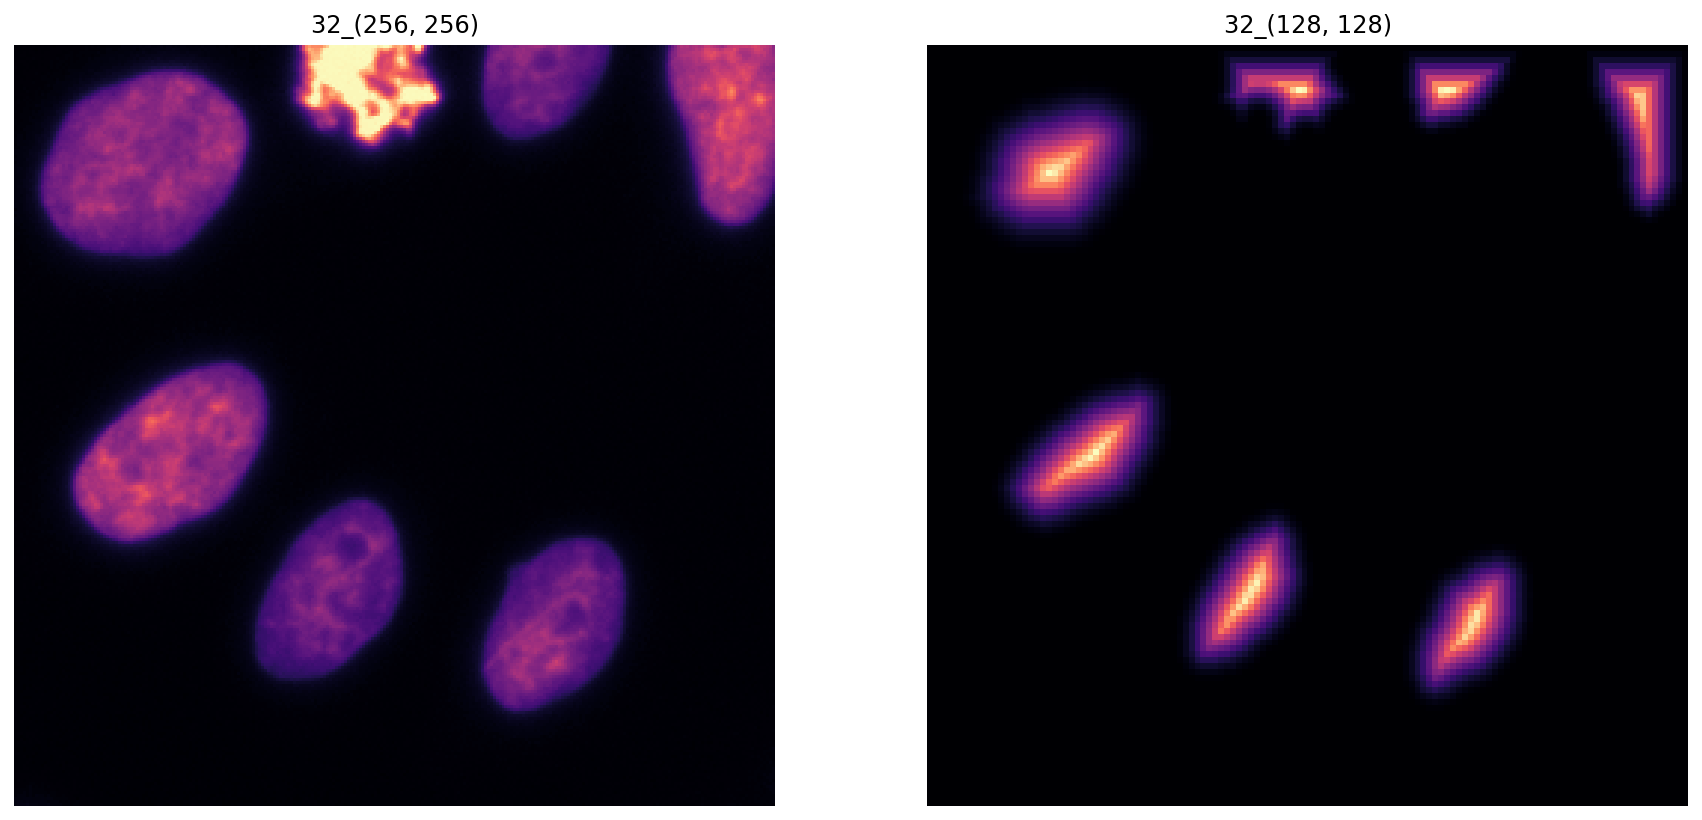

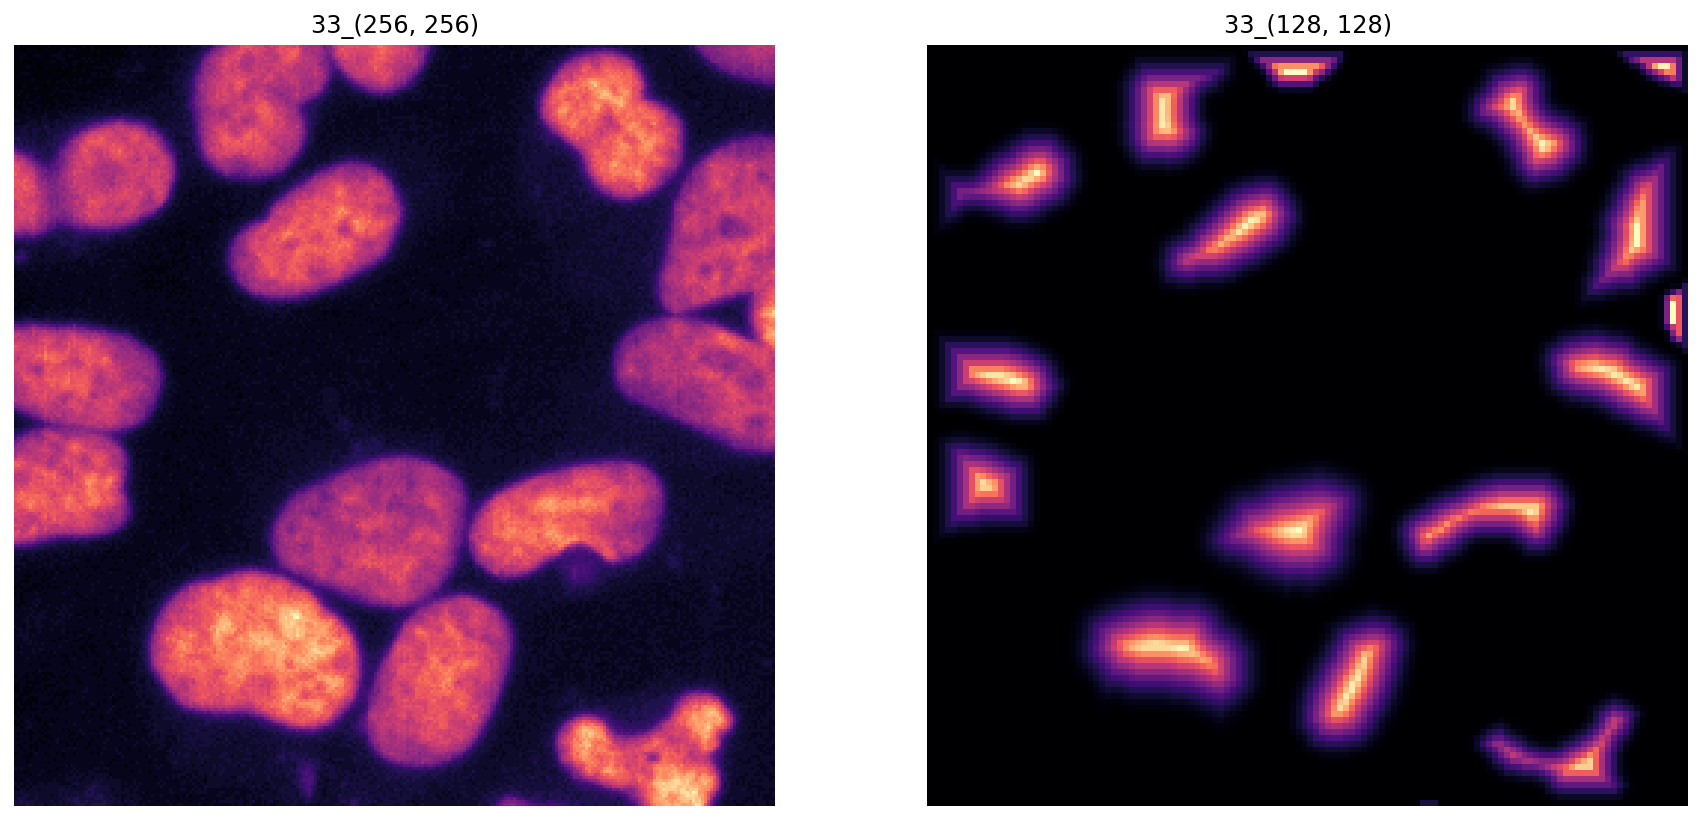

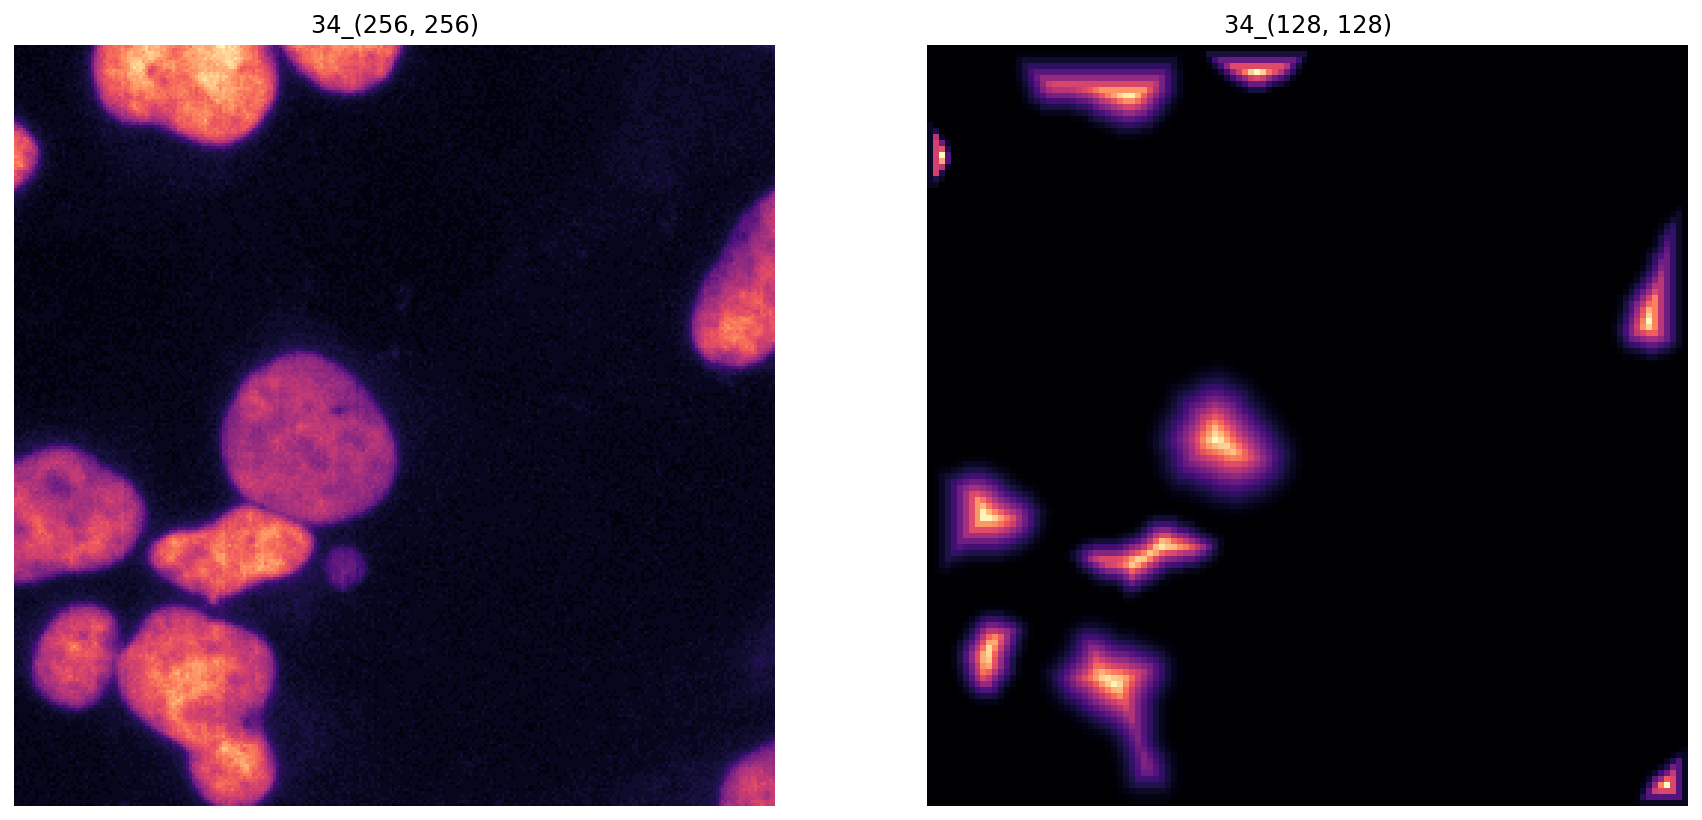

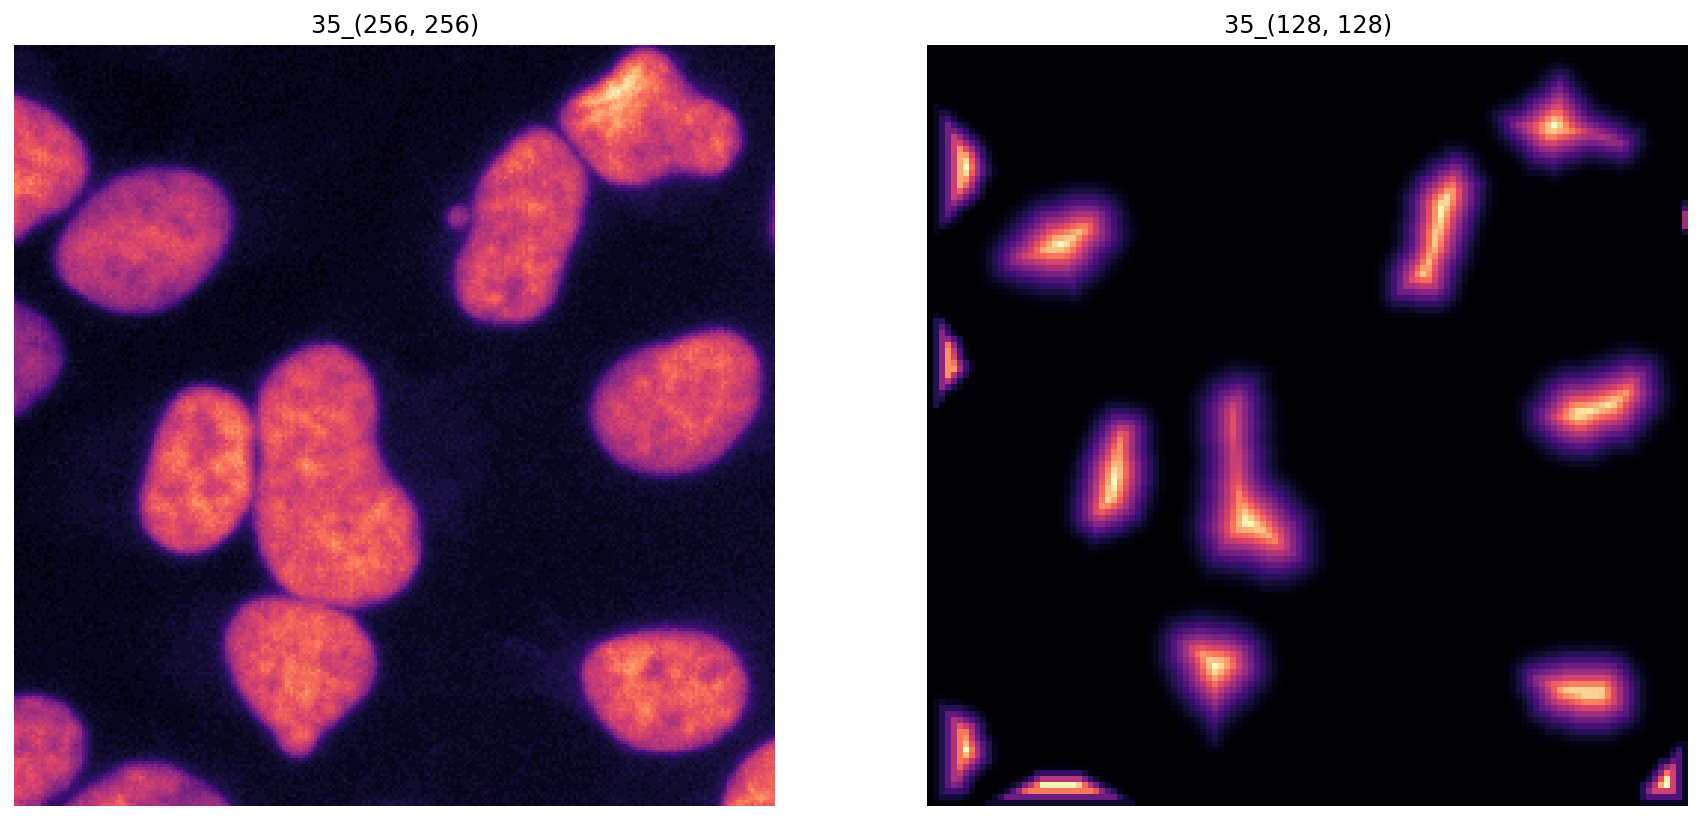

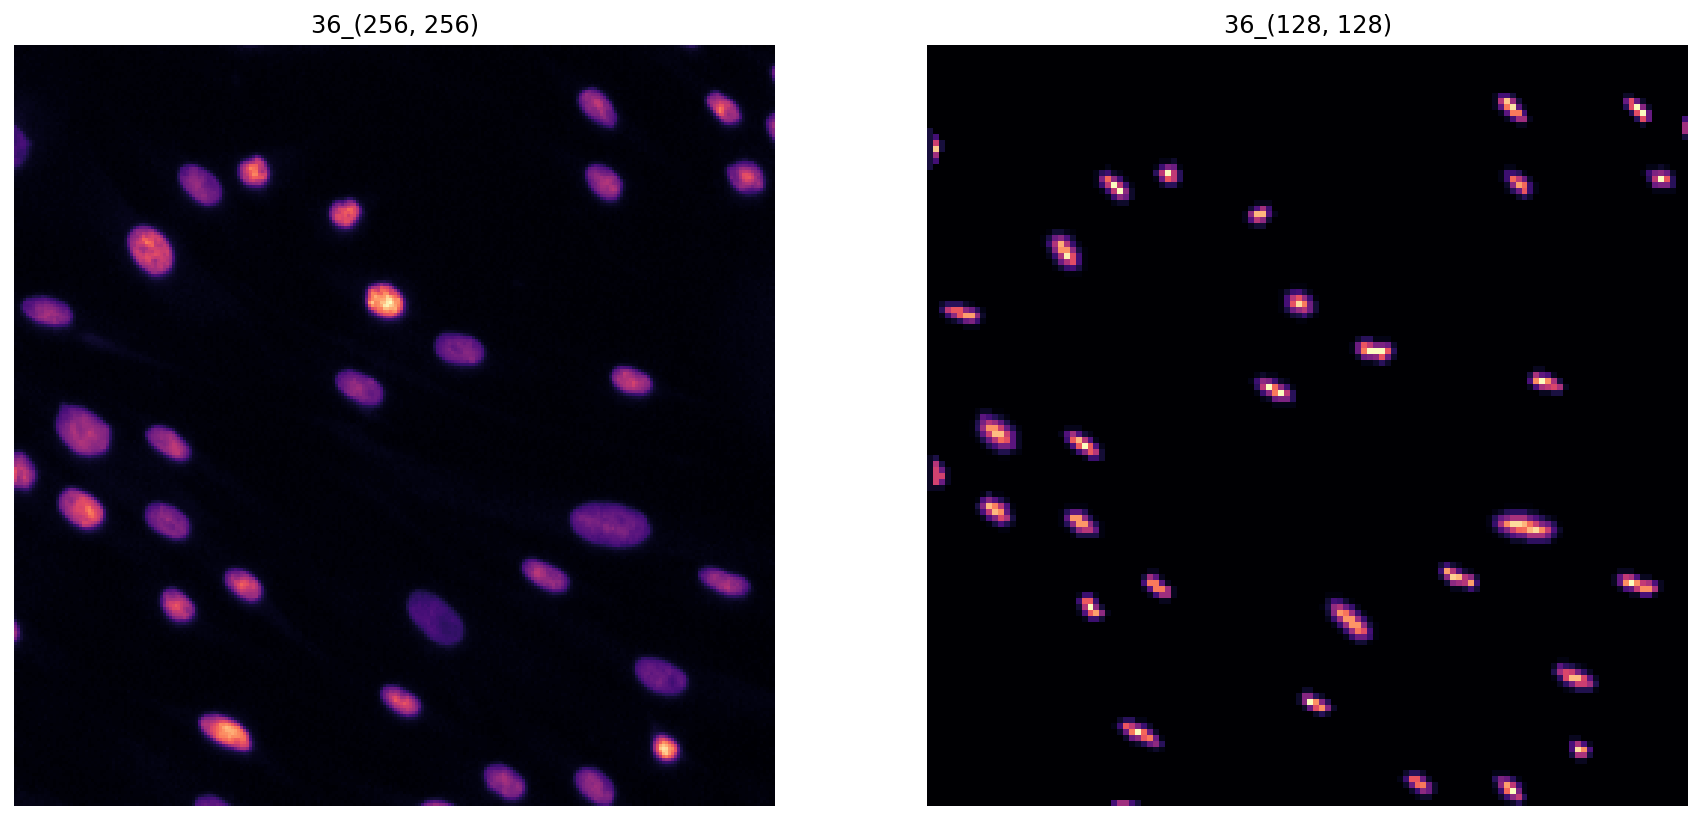

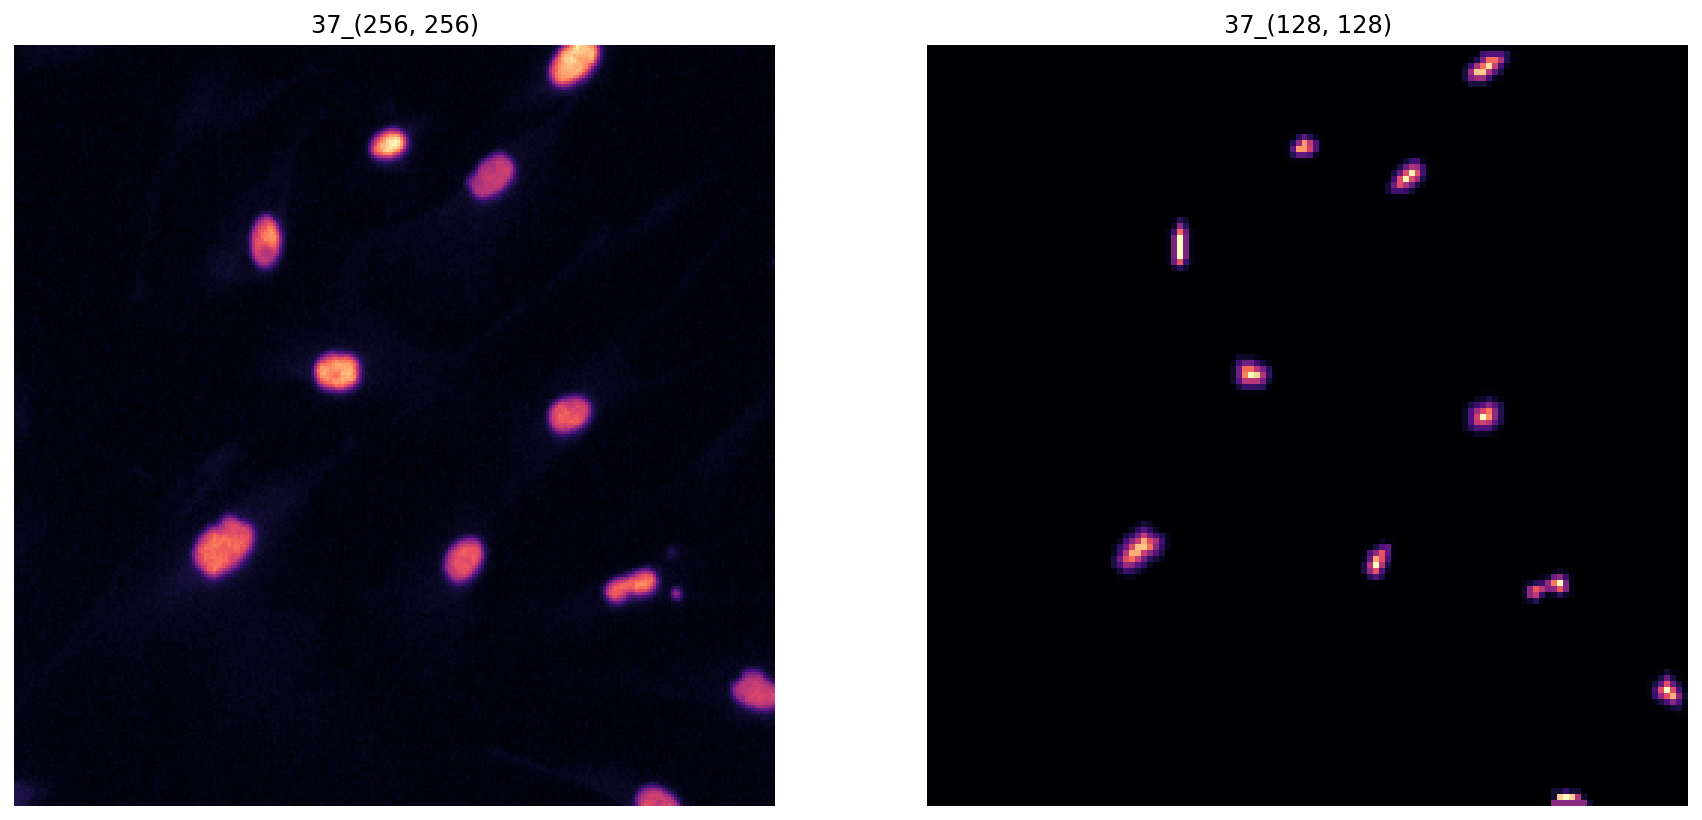

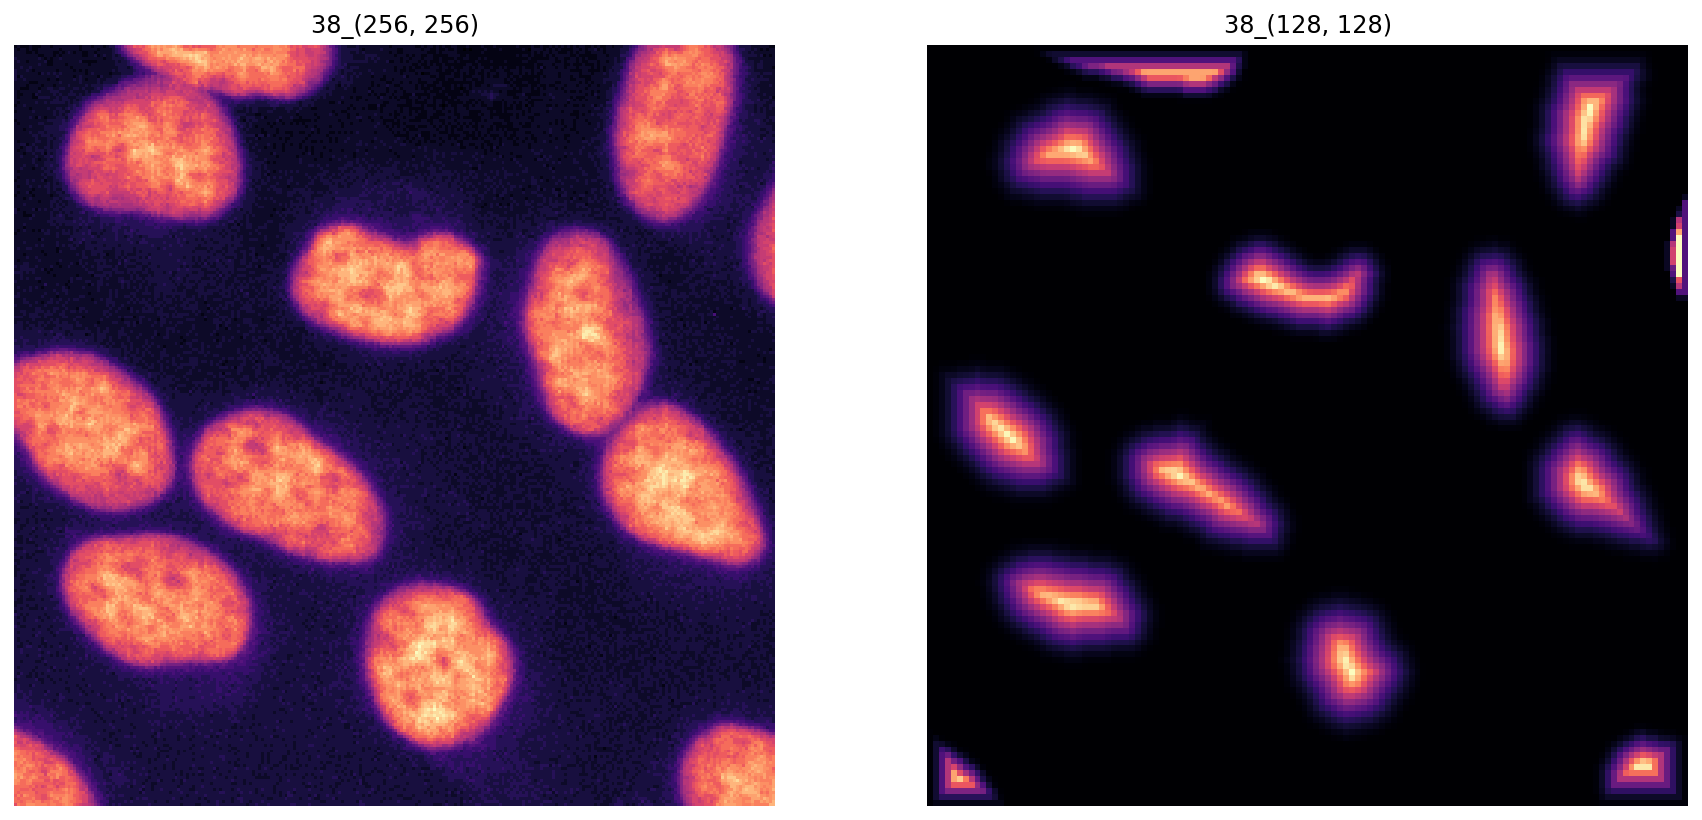

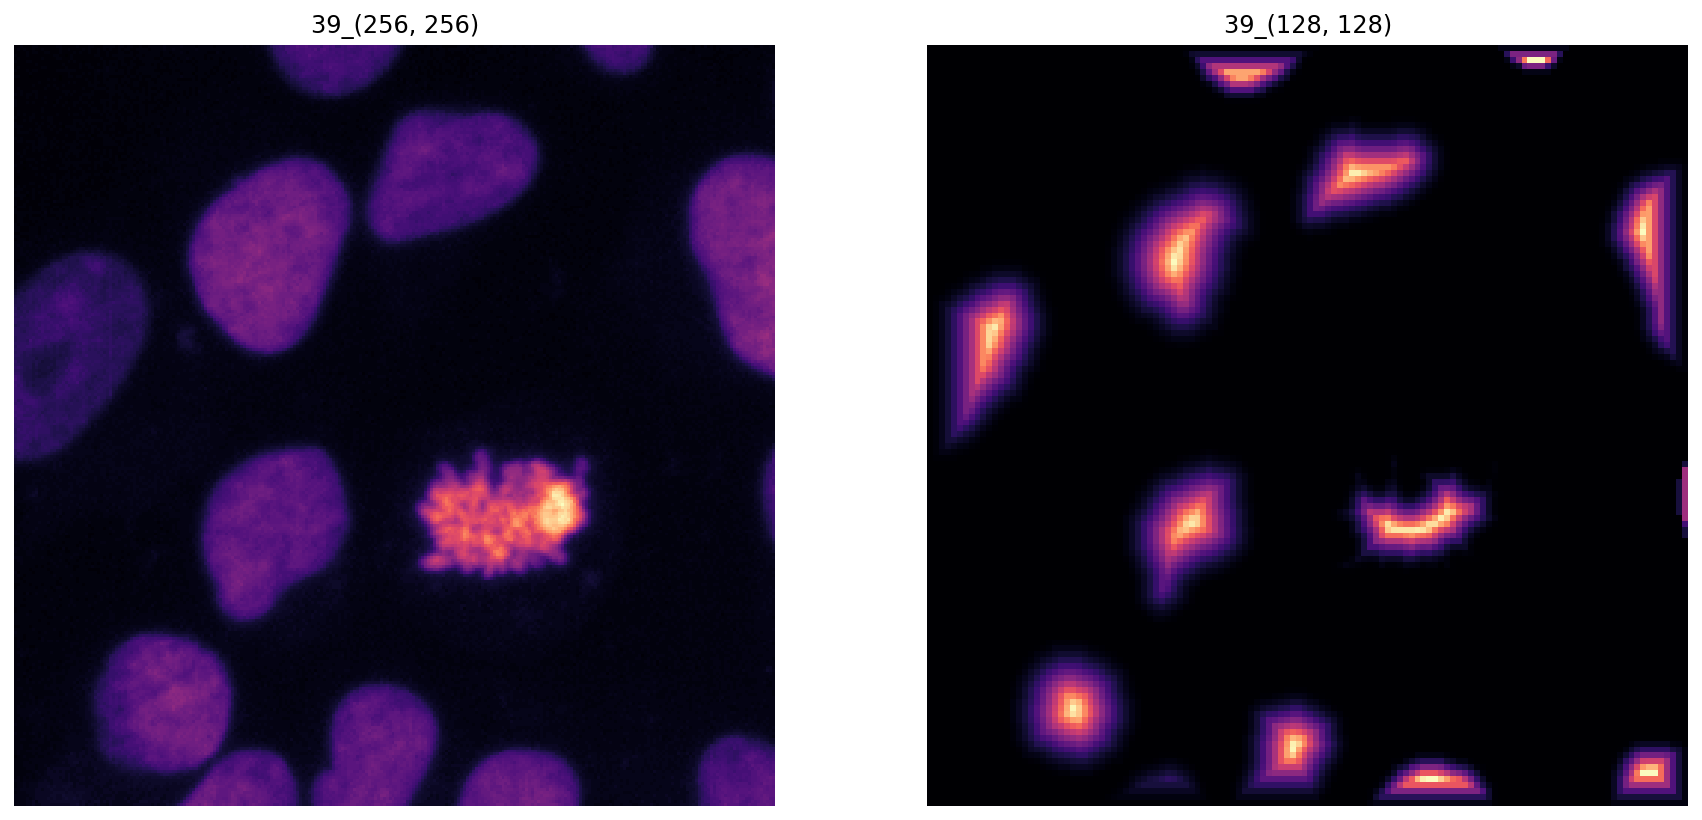

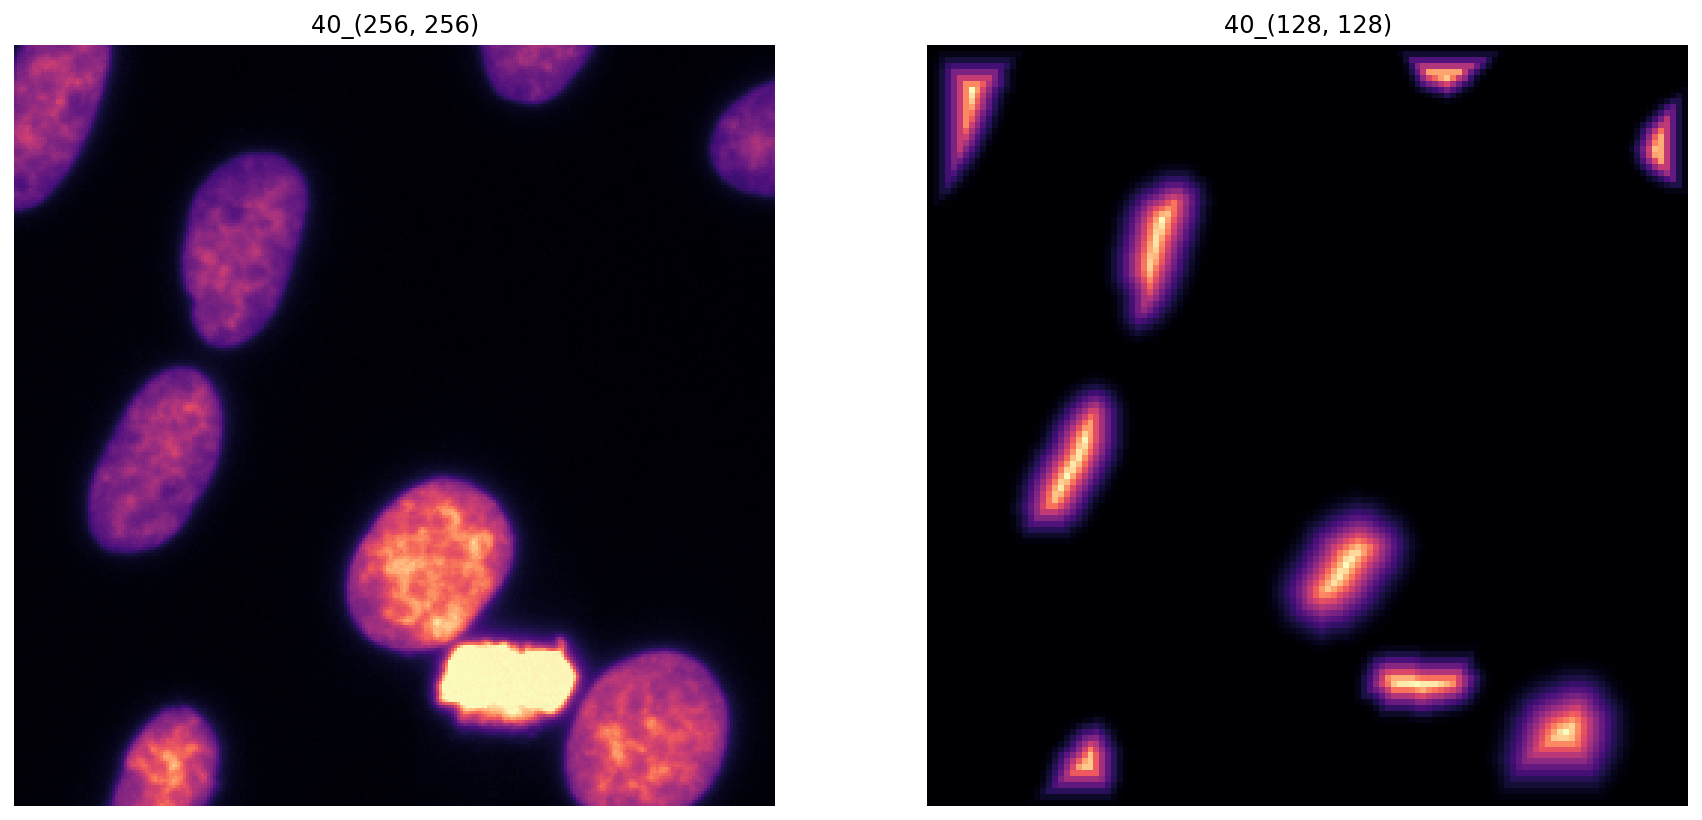

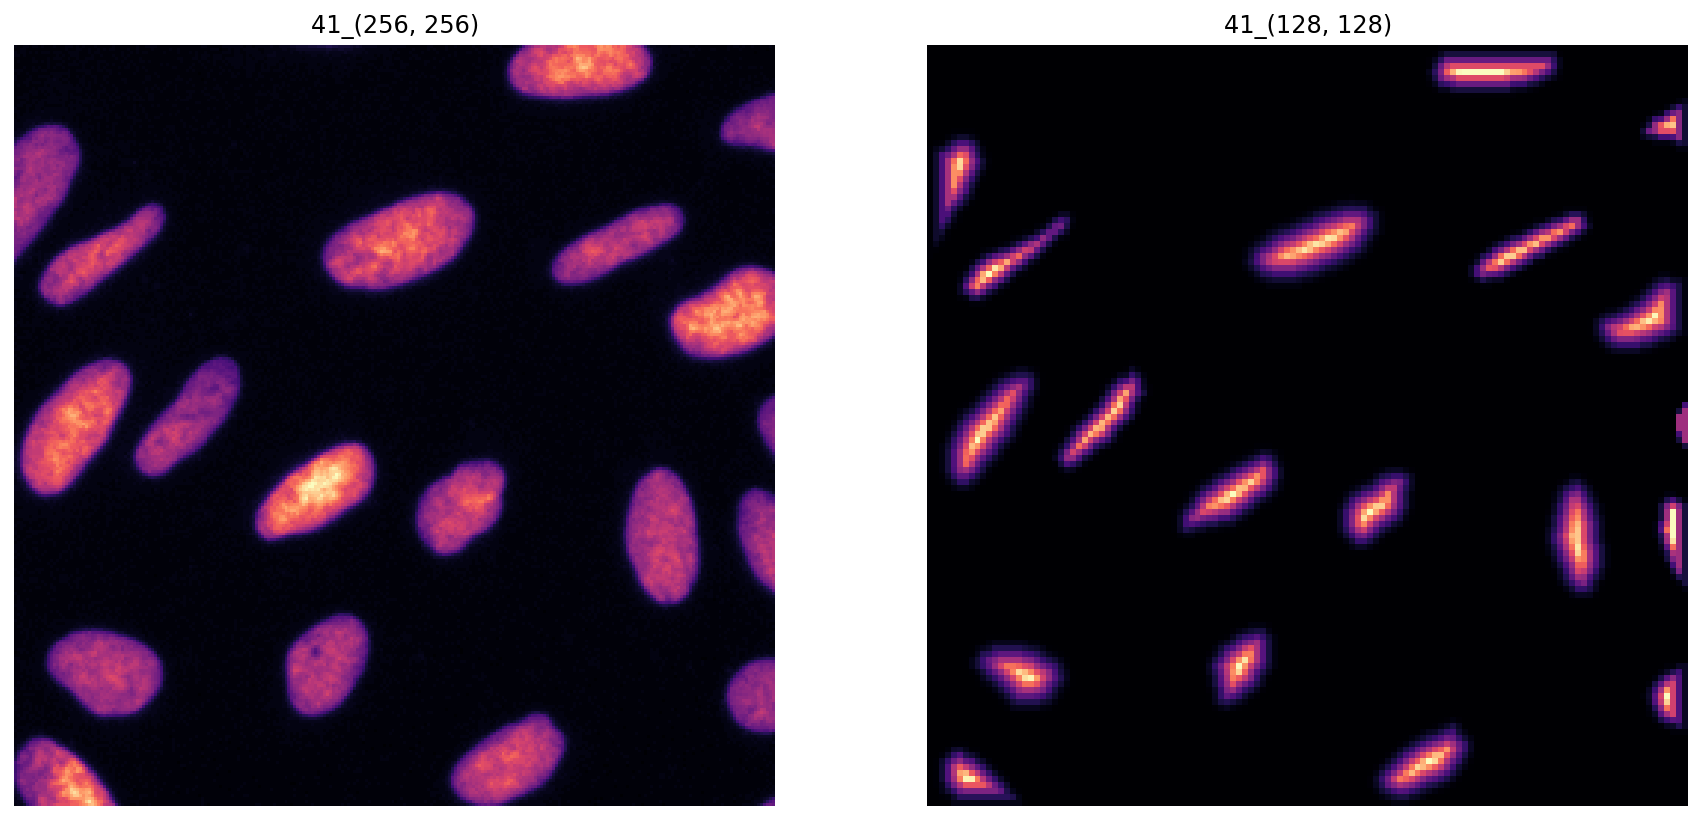

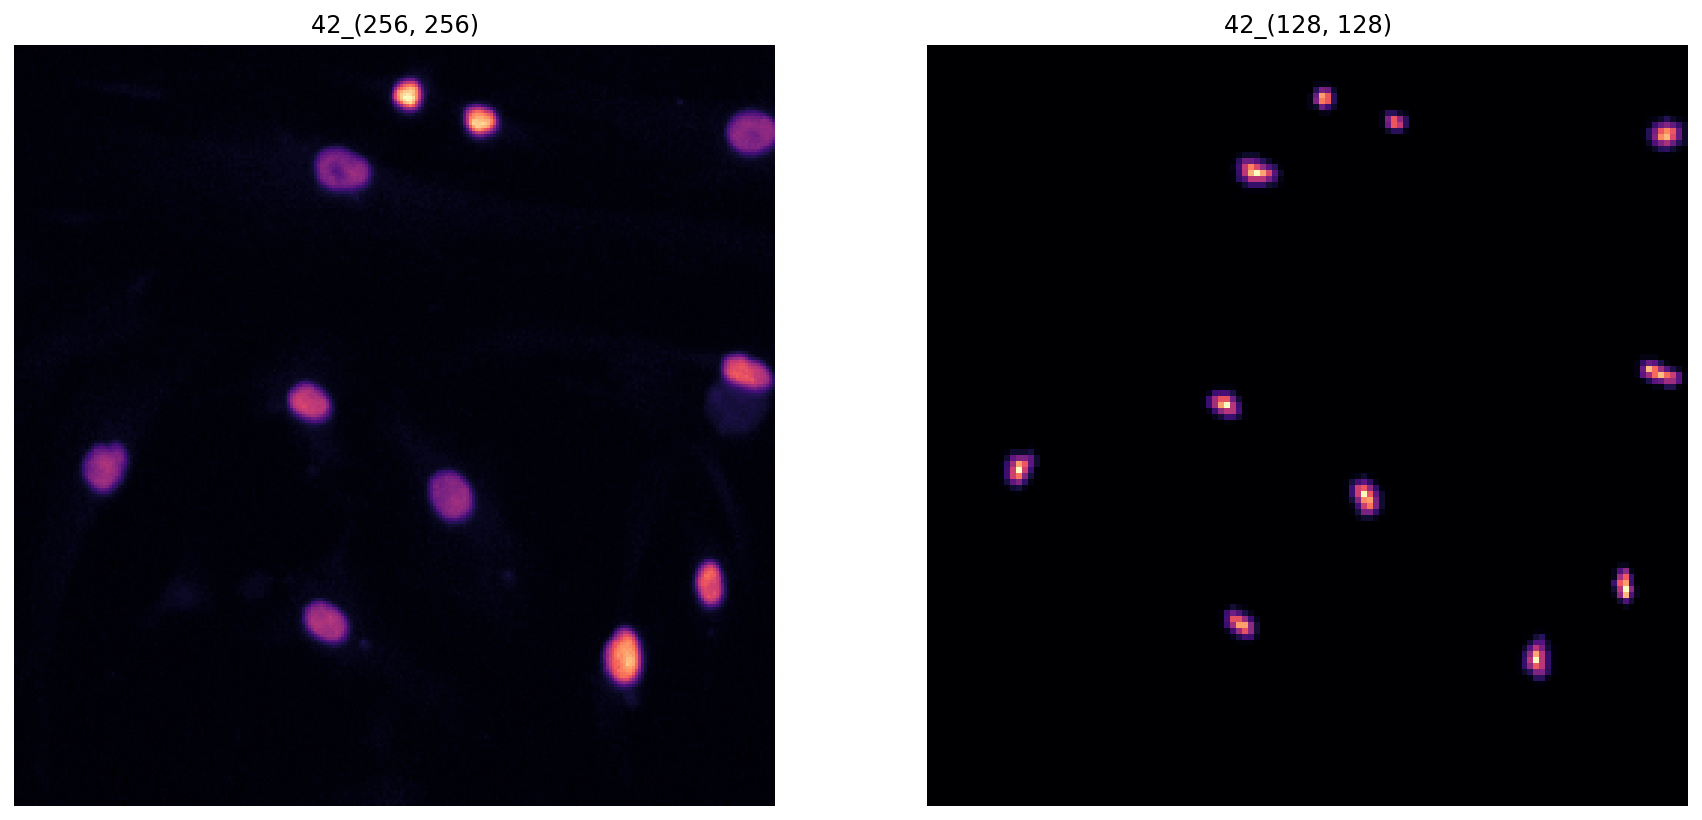

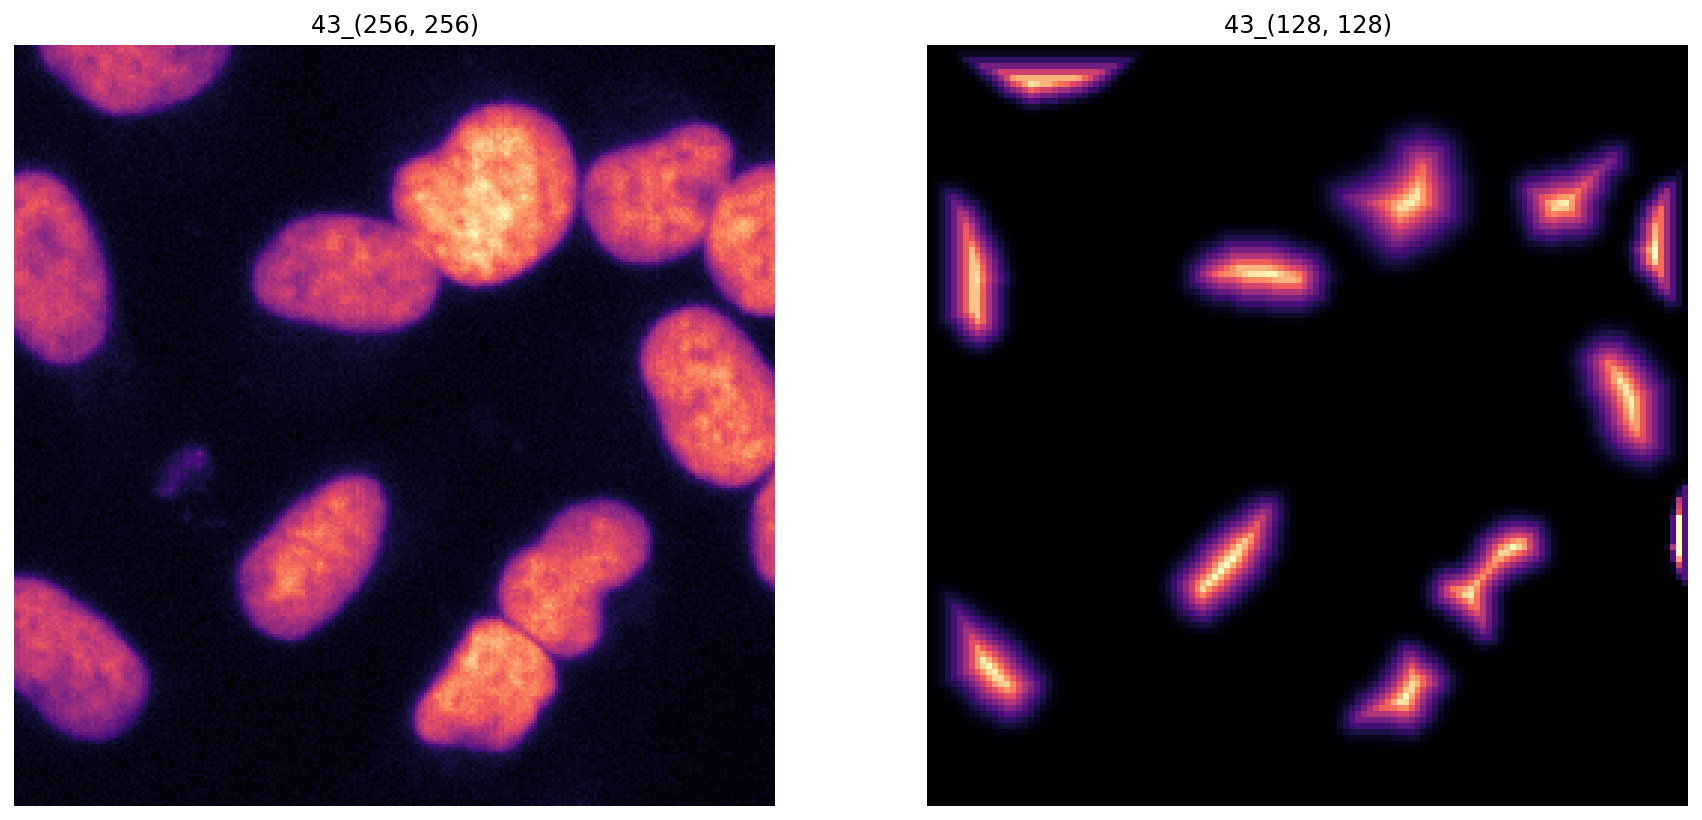

In [57]:
a = zip(*[np.squeeze(out, axis=-1) for out in X_batch])
vmin=None
vmax=None 
cmap='magma'
figsize=(15,15)

plt.close('all')

for i, arr in enumerate(a):
    col = len(arr)
    plt.figure(figsize=figsize)   
    for c in range(0,col):
        plt.subplot(1, col, c+1)
        if isinstance(arr, tuple): img = arr[c]
        else: img = arr
        plt.title(f'{i}_{img.shape}') 
        plt.imshow(img,vmin=vmin, vmax=vmax, cmap=cmap)
        plt.axis('off')

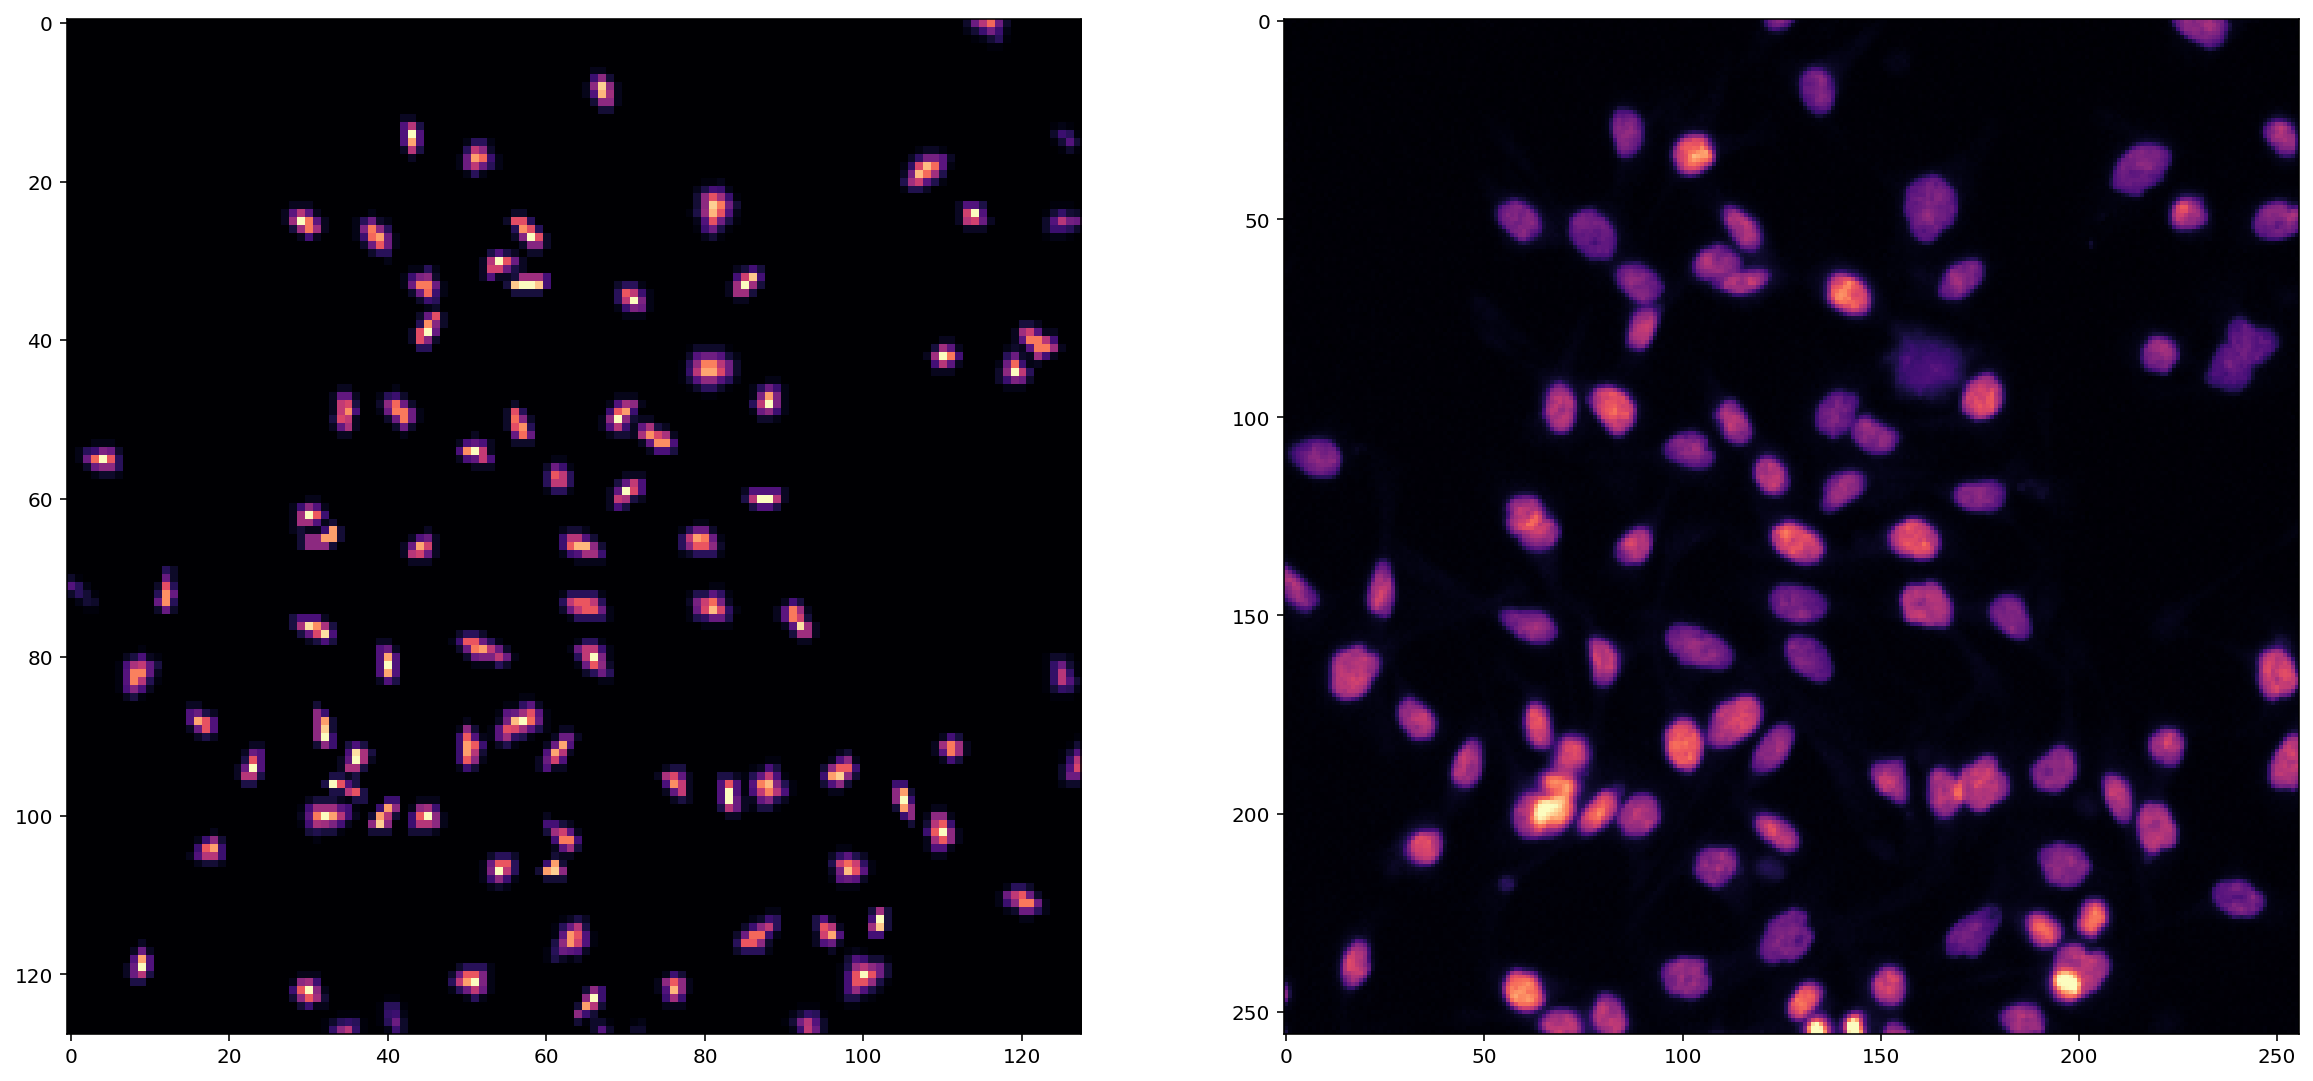

In [34]:
i = 0
img = np.squeeze(X_batch[1][i])
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img, cmap='magma')
plt.subplot(122)
plt.imshow(np.squeeze(X_batch[0][i]), cmap='magma')
plt.show()
# np.savetxt(f'{i}.txt', img, delimiter=',')

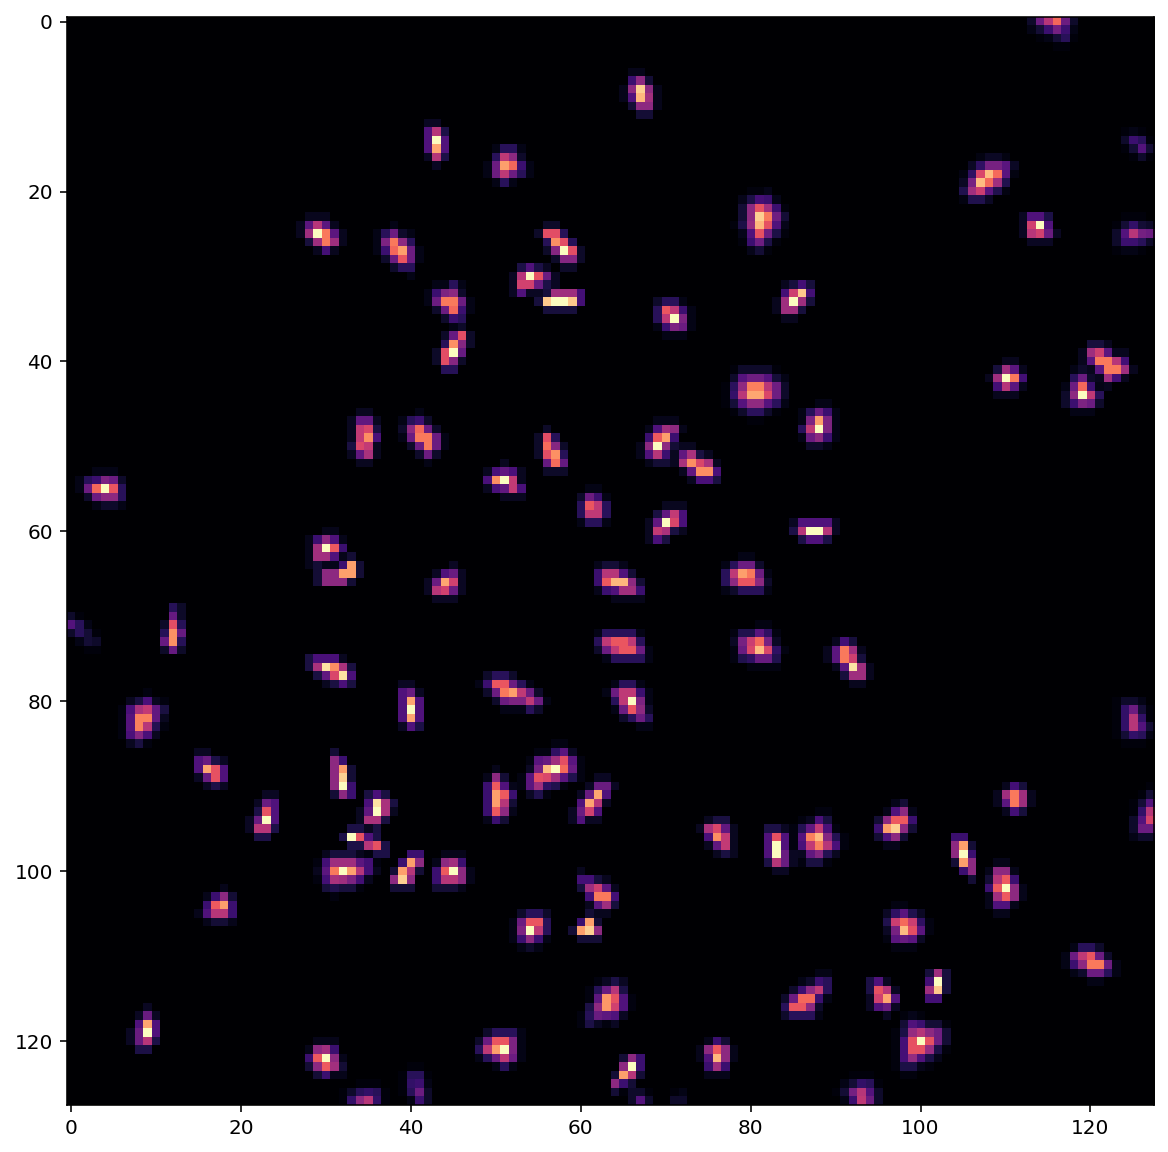

In [35]:
i = 0
img = np.squeeze(X_batch[1][i])
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='magma')
np.savetxt(f'{i}.txt', img, delimiter=',')

In [53]:
img[:,0]

array([242., 196., 144., 100.,  64.,  36.,  16.,   4.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,  26.,  34.,  50.,  74., 106., 101.,  65.,  37.,  17.,
         5.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,  50.,  58.,  74.,  64.,  36.,  16.,   4.,   0.,   0.,
        inf,  inf,  inf,  inf,   4.,  16.,  25.,   9.,   1.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   4.,   8.,  13.,  16.,  20.,  32.,  41.,  25.,  17.,  10.,
         5.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.], dtype=float32)

In [ ]:
6,26,31

In [30]:
import edt
# help(edt)
i = 0
# plt.imshow(np.squeeze(Y_val[0]))
lbl = np.squeeze(Y_val[i])
e = edt.edt(Y_val[i])
e.shape

(256, 256)

7.0


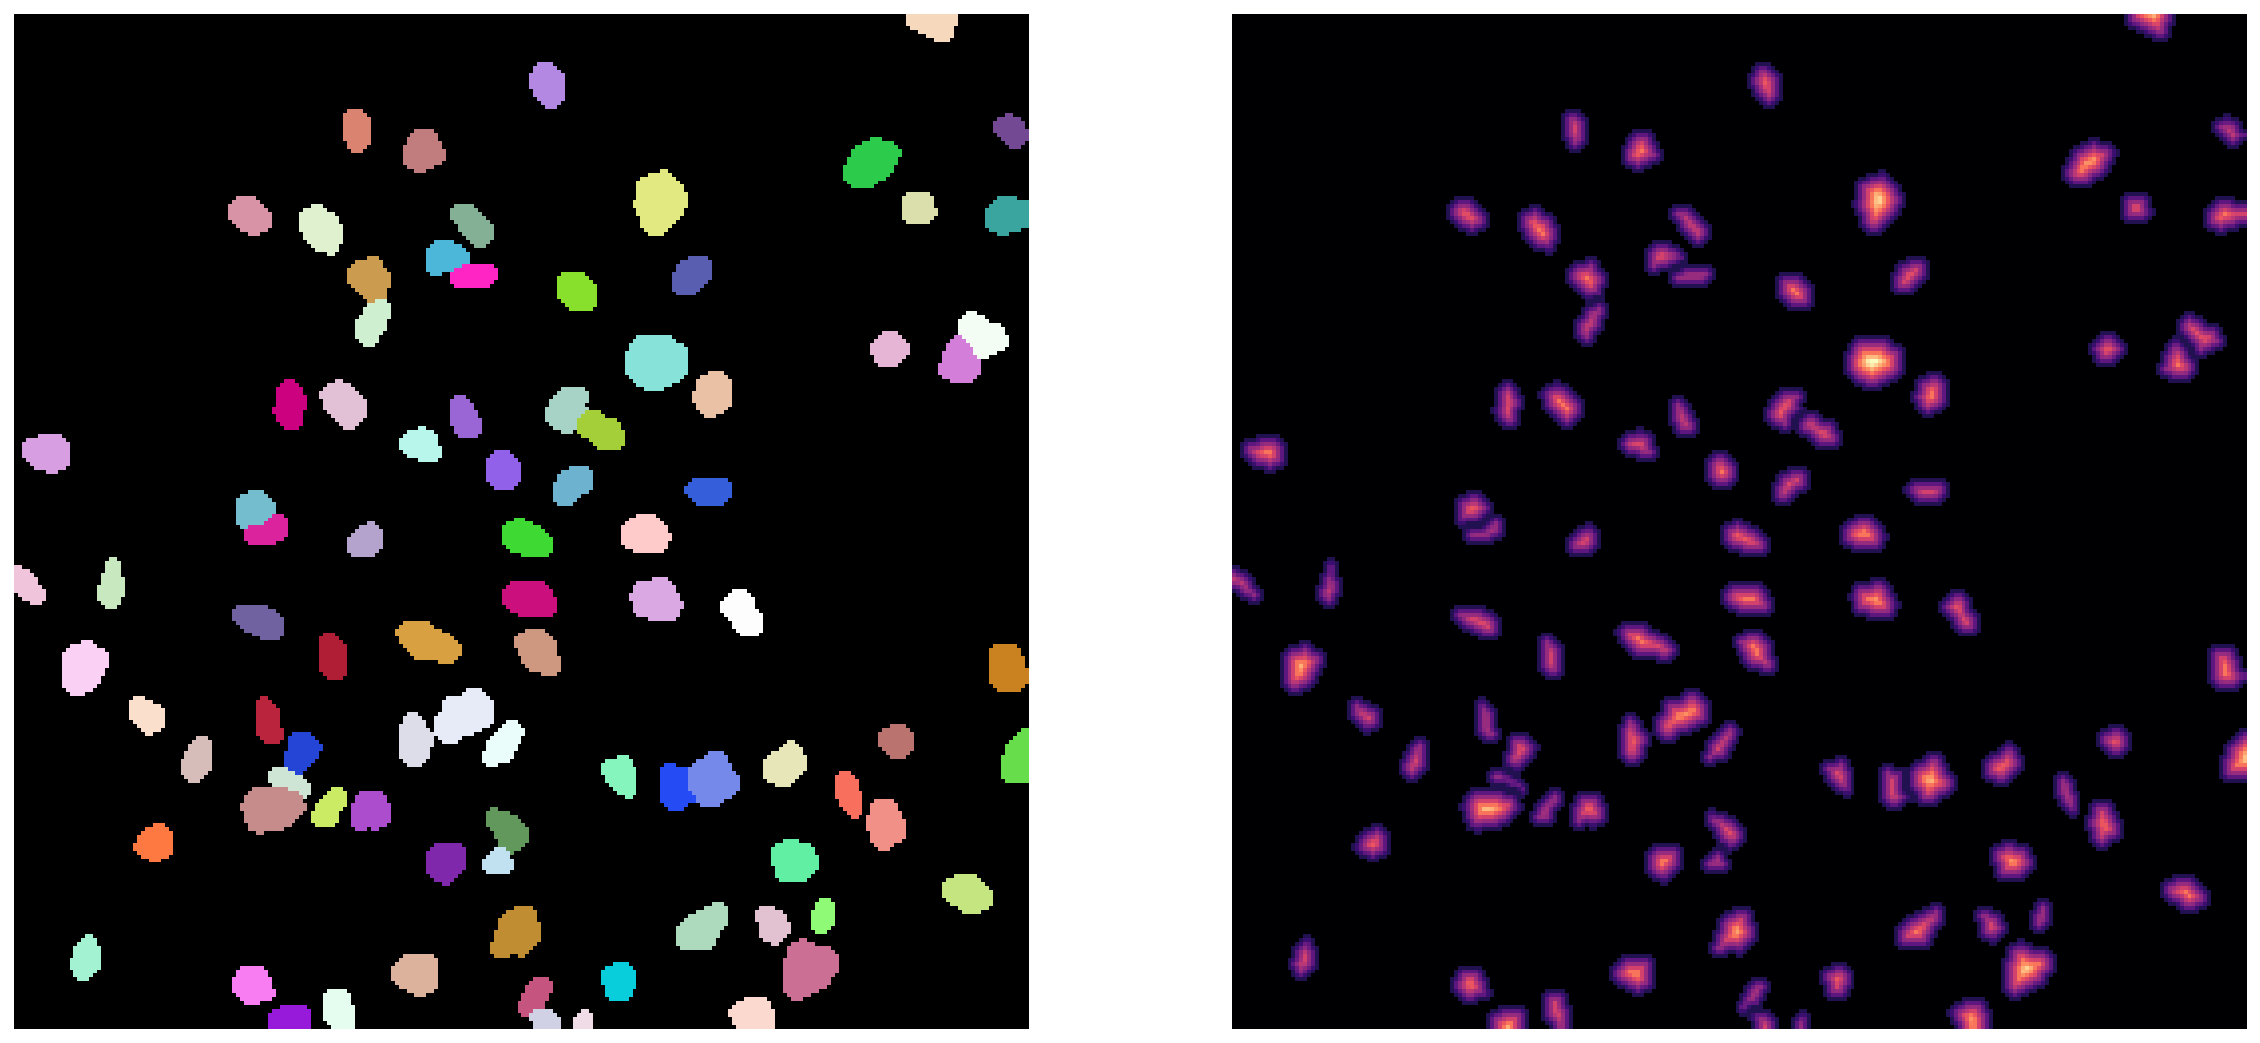

In [32]:
print(np.max(e))
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(lbl, cmap=random_label_cmap())
plt.axis('off')
plt.subplot(122)
plt.imshow(e, cmap='magma')
plt.axis('off')
plt.show()

In [27]:
np.savetxt('edt_8.txt', e, delimiter=',')

In [23]:
np.max([np.max(e), 10])

10.0

In [24]:
max(np.max(e),10)

10